Tom Genlis
# TP2 - CVID

In [175]:
import numpy as np
import matplotlib.pyplot as plt

# Read images
from matplotlib import image

# Customs matplotlib colors
from matplotlib import colors

# Read files from a directory
import glob

# Prints a neat progress bar
from tqdm.notebook import trange, tqdm

# Retina (high pixel density) plot display
%config InlineBackend.figure_format = 'retina'

In [176]:
# Load the images from the directory and normalize them
images = []
for filename in glob.glob('images/*.jpg'):
    images.append(np.asarray(image.imread(filename)) / 255)

In [177]:
def rgb2gray(rgb):
    """
    Convert an RGB image to grayscale approximating human eye perception of colors
    """
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [178]:
def plot_motion_vectors(motion_vectors, img1, offset=0.5, density=1, scale=1):
    """
    Plot a vector field in a matrix grid each step pixels
    """
    fig, ax = plt.subplots(figsize=((max(img1.shape[1] // 20, 10), \
                                     max(img1.shape[0] // 20, 10))))
    
    # Compute the step to take to get the desired density of vectors per pixel
    vec_density = (motion_vectors.shape[0] / images[0].shape[0]) * 25
    step = int(max(np.ceil(vec_density / density), 1))

    U, V = np.array(motion_vectors[::step, ::step, 0]).astype(float), \
        np.array(motion_vectors[::step, ::step, 1]).astype(float)
    X, Y = np.array(motion_vectors[::step, ::step, 2]).astype(float) \
        + offset, np.array(motion_vectors[::step, ::step, 3]).astype(float) + offset

    angle = np.arctan2(U, V)

    # Plot the grid
    ax.imshow(rgb2gray(img1), cmap='gray')

    # Draw the vectors from (Xi, Yi) to (Ui, Vi)
    # Their color is a lerp according to the angle
    # Their norm needs to be greater than 0 to be drawn
    ax.quiver(Y, X, V, U, angle, angles='xy', scale_units='xy', pivot="tail", \
              scale=1/scale, color='r', minshaft = 1, minlength=0)

    # Show the result
    plt.show()

In [179]:
def plot_images_motion_vectors(motion_vectors, img_size):
    """
    Plot the motion vectors in 3 different images (X, Y, norm)
    """
    # Split vectors components into X and Y lists
    X, Y = motion_vectors[:, :, 0], motion_vectors[:, :, 1]
    # Calculate their norm
    N = np.sqrt(X ** 2 + Y ** 2)
    A = np.arctan2(X, Y)
    
    figsize = ((max(img_size[1] // 20, 10), max(img_size[0] // 20, 10)))
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)

    # Custom lerp color map
    cmap_n = colors.LinearSegmentedColormap.from_list('mycmap2', ['white', 'black'])

    cmin, cmax = -np.pi, np.pi
    # Plot the images
    im1 = ax1.imshow(A, vmin=cmin, vmax=cmax)
    cb = fig.colorbar(im1, ax=ax1, label="Angle")
    cb.set_ticks(np.linspace(cmin, cmax, 5))
    cb.set_ticklabels( \
        ['-π (left)', '-π/2 (top)', '0 (right or zero vector)', 'π/2 (bottom)', 'π (left)'])

    im2 = ax2.imshow(N, cmap=cmap_n)
    fig.colorbar(im2, ax=ax2, label="Norm", cmap=cmap_n)

    # Show the result
    plt.show()

(A) Au TP1, vous avez réalisé de l’estimation de mouvement de type forward
par blocs entre F1 et F2. Procédez maintenant à de l’estimation backward par
blocs entre F1 et F2.
Note : c’est désormais F2 que l’on décompose en blocs et non pas F1.

In [180]:
def bma_block(frame1, frame2, block_size, search_range):
    """
    Calculate the motion vector matrix using the BMA algorithm
    """

    # Gray the frames to get intensity images (human eye gray)
    frame1 = rgb2gray(frame1)
    frame2 = rgb2gray(frame2)

    # Ignore borders of the image to avoid border cases
    hpad = block_size // 2 + search_range
    wpad = block_size // 2 + search_range

    # Calculate blocs per image size (constant across all frames)
    height, width = frame1.shape
    b_height, b_width = np.array(frame1.shape) // block_size

    # Vector field matrix
    vector_field = np.empty((b_height, b_width, 4), dtype=np.float32)

    # Iterate over each IP in the current frame
    for a in trange(b_height):
        for b in range(b_width):
            # Extract the current block (block around the center IP (i, j)) and avoid corners
            i, j = a * block_size, b * block_size
            current_block = frame2[i+hpad:i+hpad+block_size, j+wpad:j+wpad+block_size]

            # Initialize the error and motion vector for the window sliding block
            best_error = np.inf
            best_motion = None
            best_distance = np.inf

            # Iterate over each pixel in the search range (sliding window)
            # Max and min assure not to slide outside the image ranges
            for k in range(max(i-search_range, 0), min(i+search_range, height-block_size)):
                for l in range(max(j-search_range, 0), min(j+search_range, width-block_size)):
                    # Extract the window block from frame1
                    window_block = frame1[k+hpad:k+hpad+block_size, l+wpad:l+wpad+block_size]

                    # Calculate the mean absolute error between the current block (in frame 2)
                    # and the search block (sliding window block in frame 1) (power 1) (DFD)
                    try:
                        dfd = np.sum(np.abs(current_block - window_block))
                    except:
                        continue
                    error = dfd

                    # Calculate the euclidian distance between the current IP and the search IP
                    # In order to prioritize the closest IP if the error is equal
                    distance =  (k - i) ** 2 + (l - j) ** 2

                    # (If the current error is lower update the best error
                    # or if the current error is equal but the distance lower) then
                    # update the motion vector
                    if error < best_error or (error == best_error and distance < best_distance):	
                        best_error = error
                        best_distance = distance
                        best_motion = np.array([k-i, l-j, i, j], dtype=np.float32)

            # Store the best motion vector for the current IP (at the center of the block)
            # in the vector field
            vector_field[a, b] = best_motion

    return vector_field

In [181]:
def bma_imgs(i, j, block_size, search_range):
    vectors = bma_block(images[i], images[j], block_size, search_range)
    
    # scaled up the vectors by 3 to be able to see them easily
    plot_motion_vectors(vectors, images[i], block_size * 2, 1, 3)
    plot_images_motion_vectors(vectors, images[i].shape)

  0%|          | 0/32 [00:00<?, ?it/s]

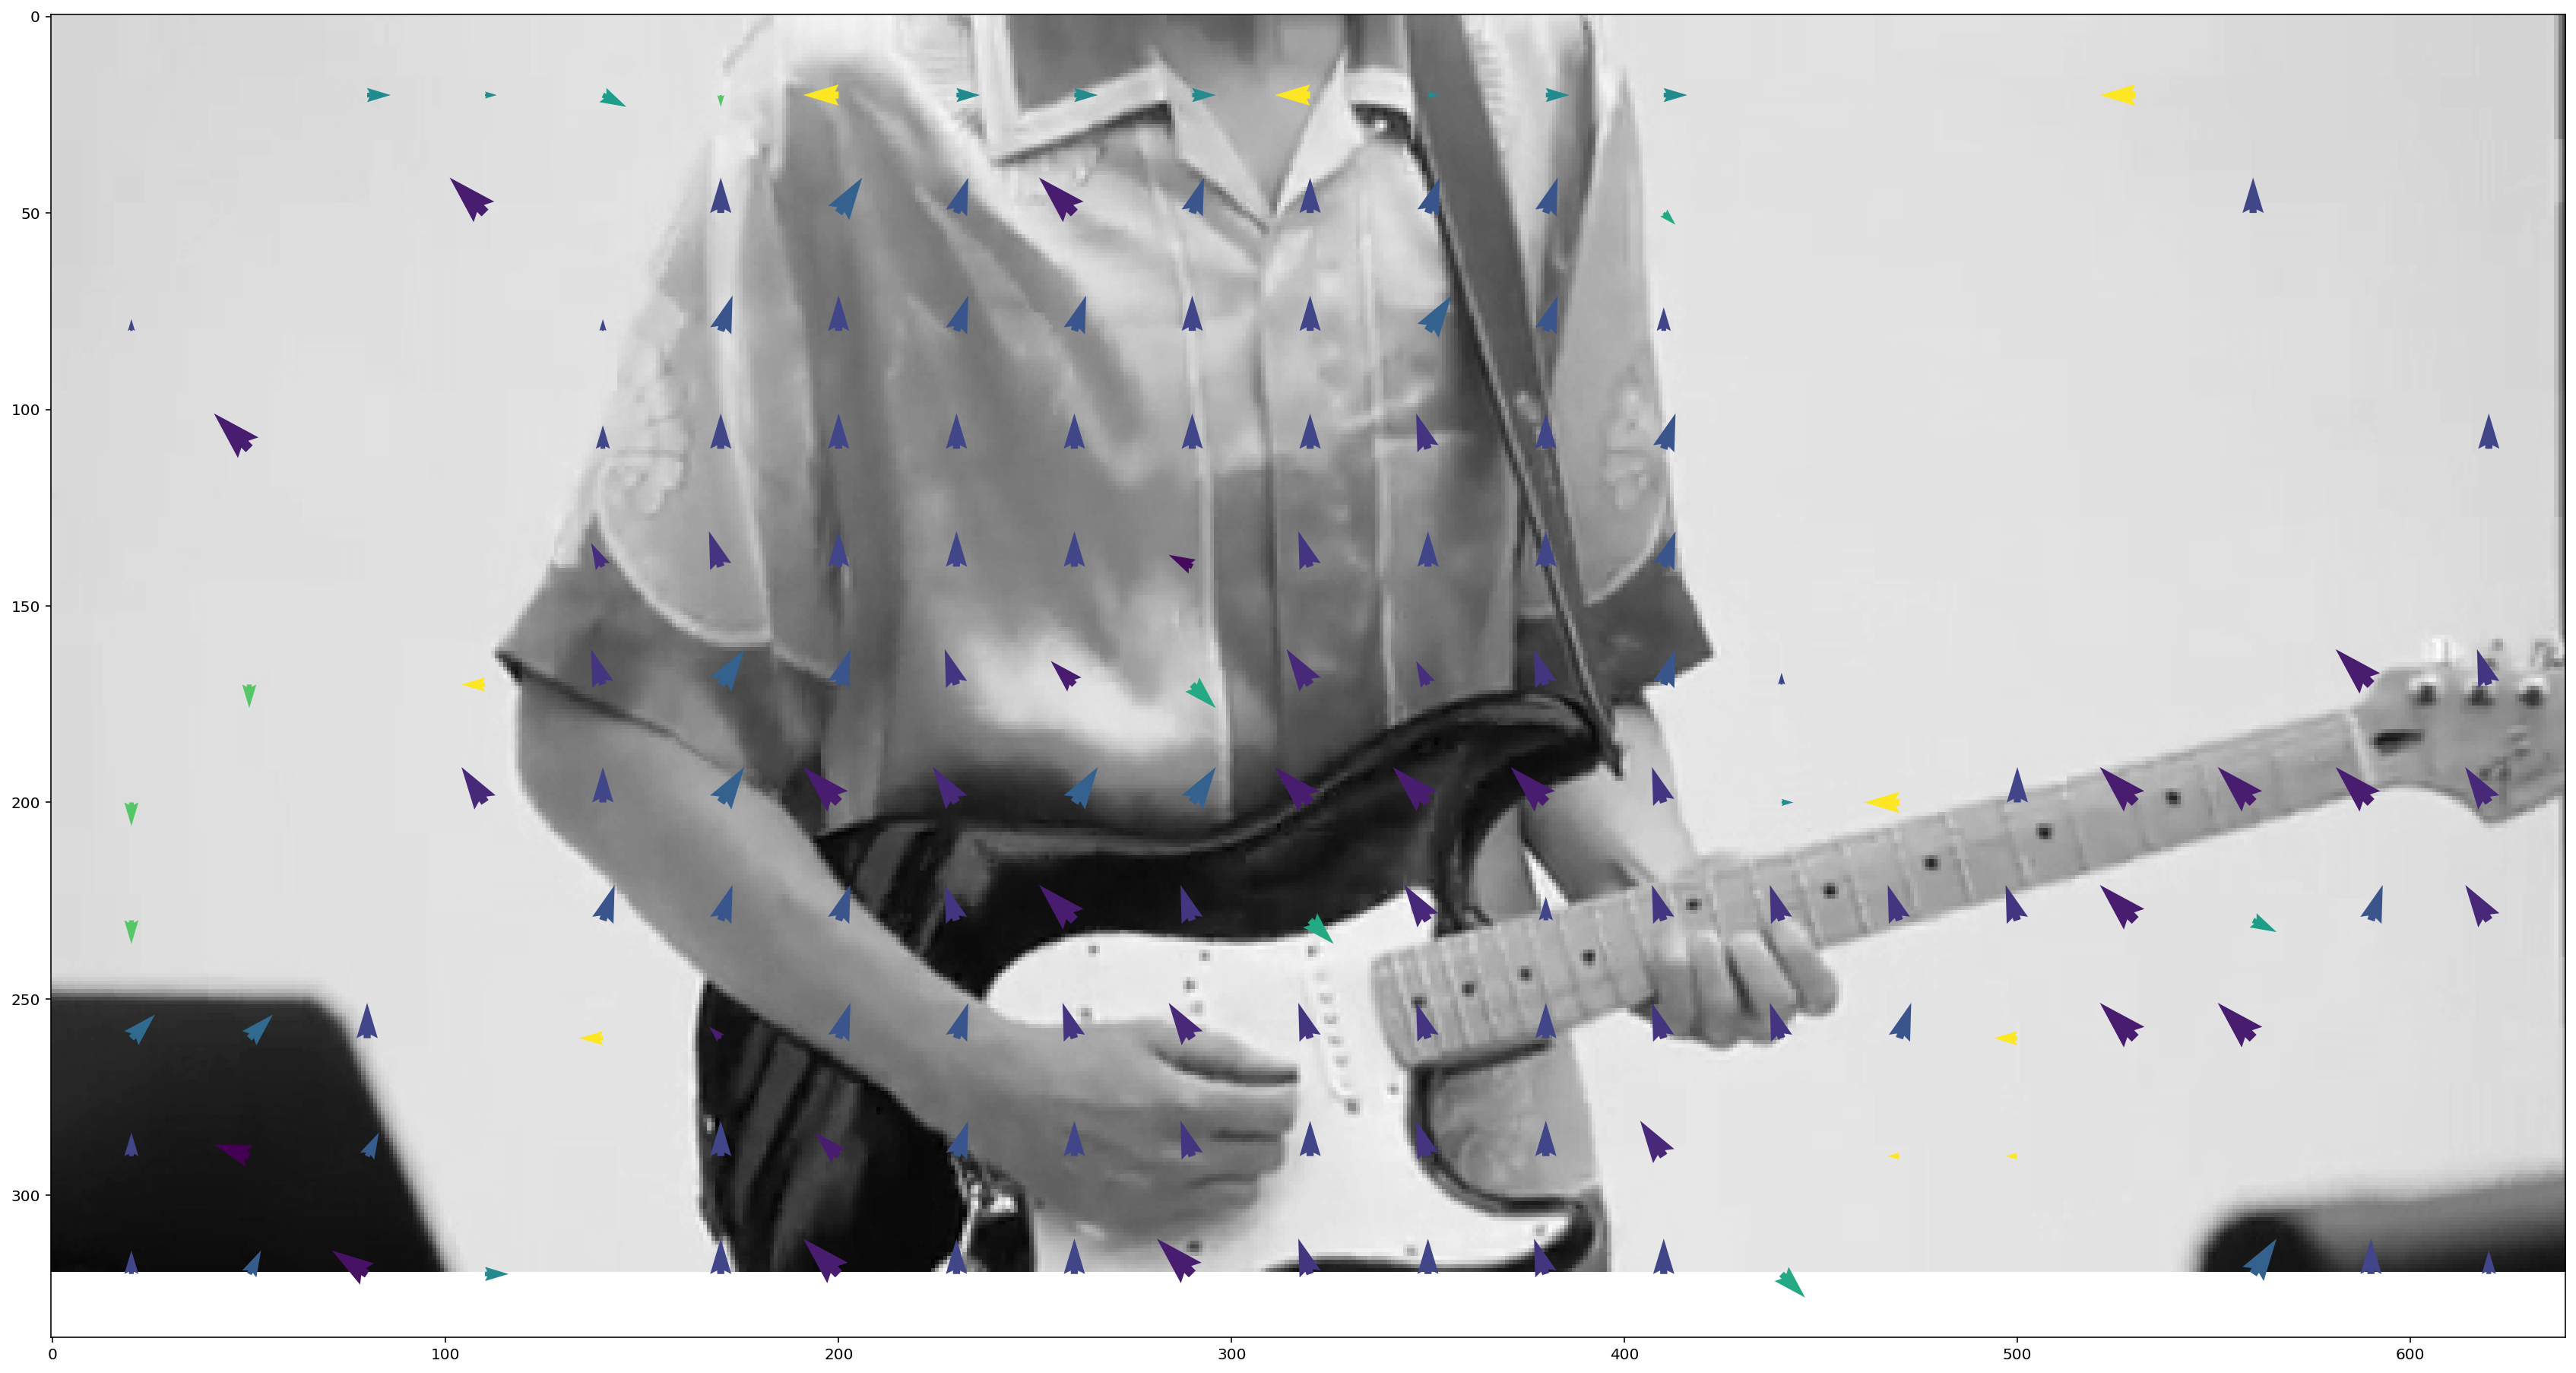

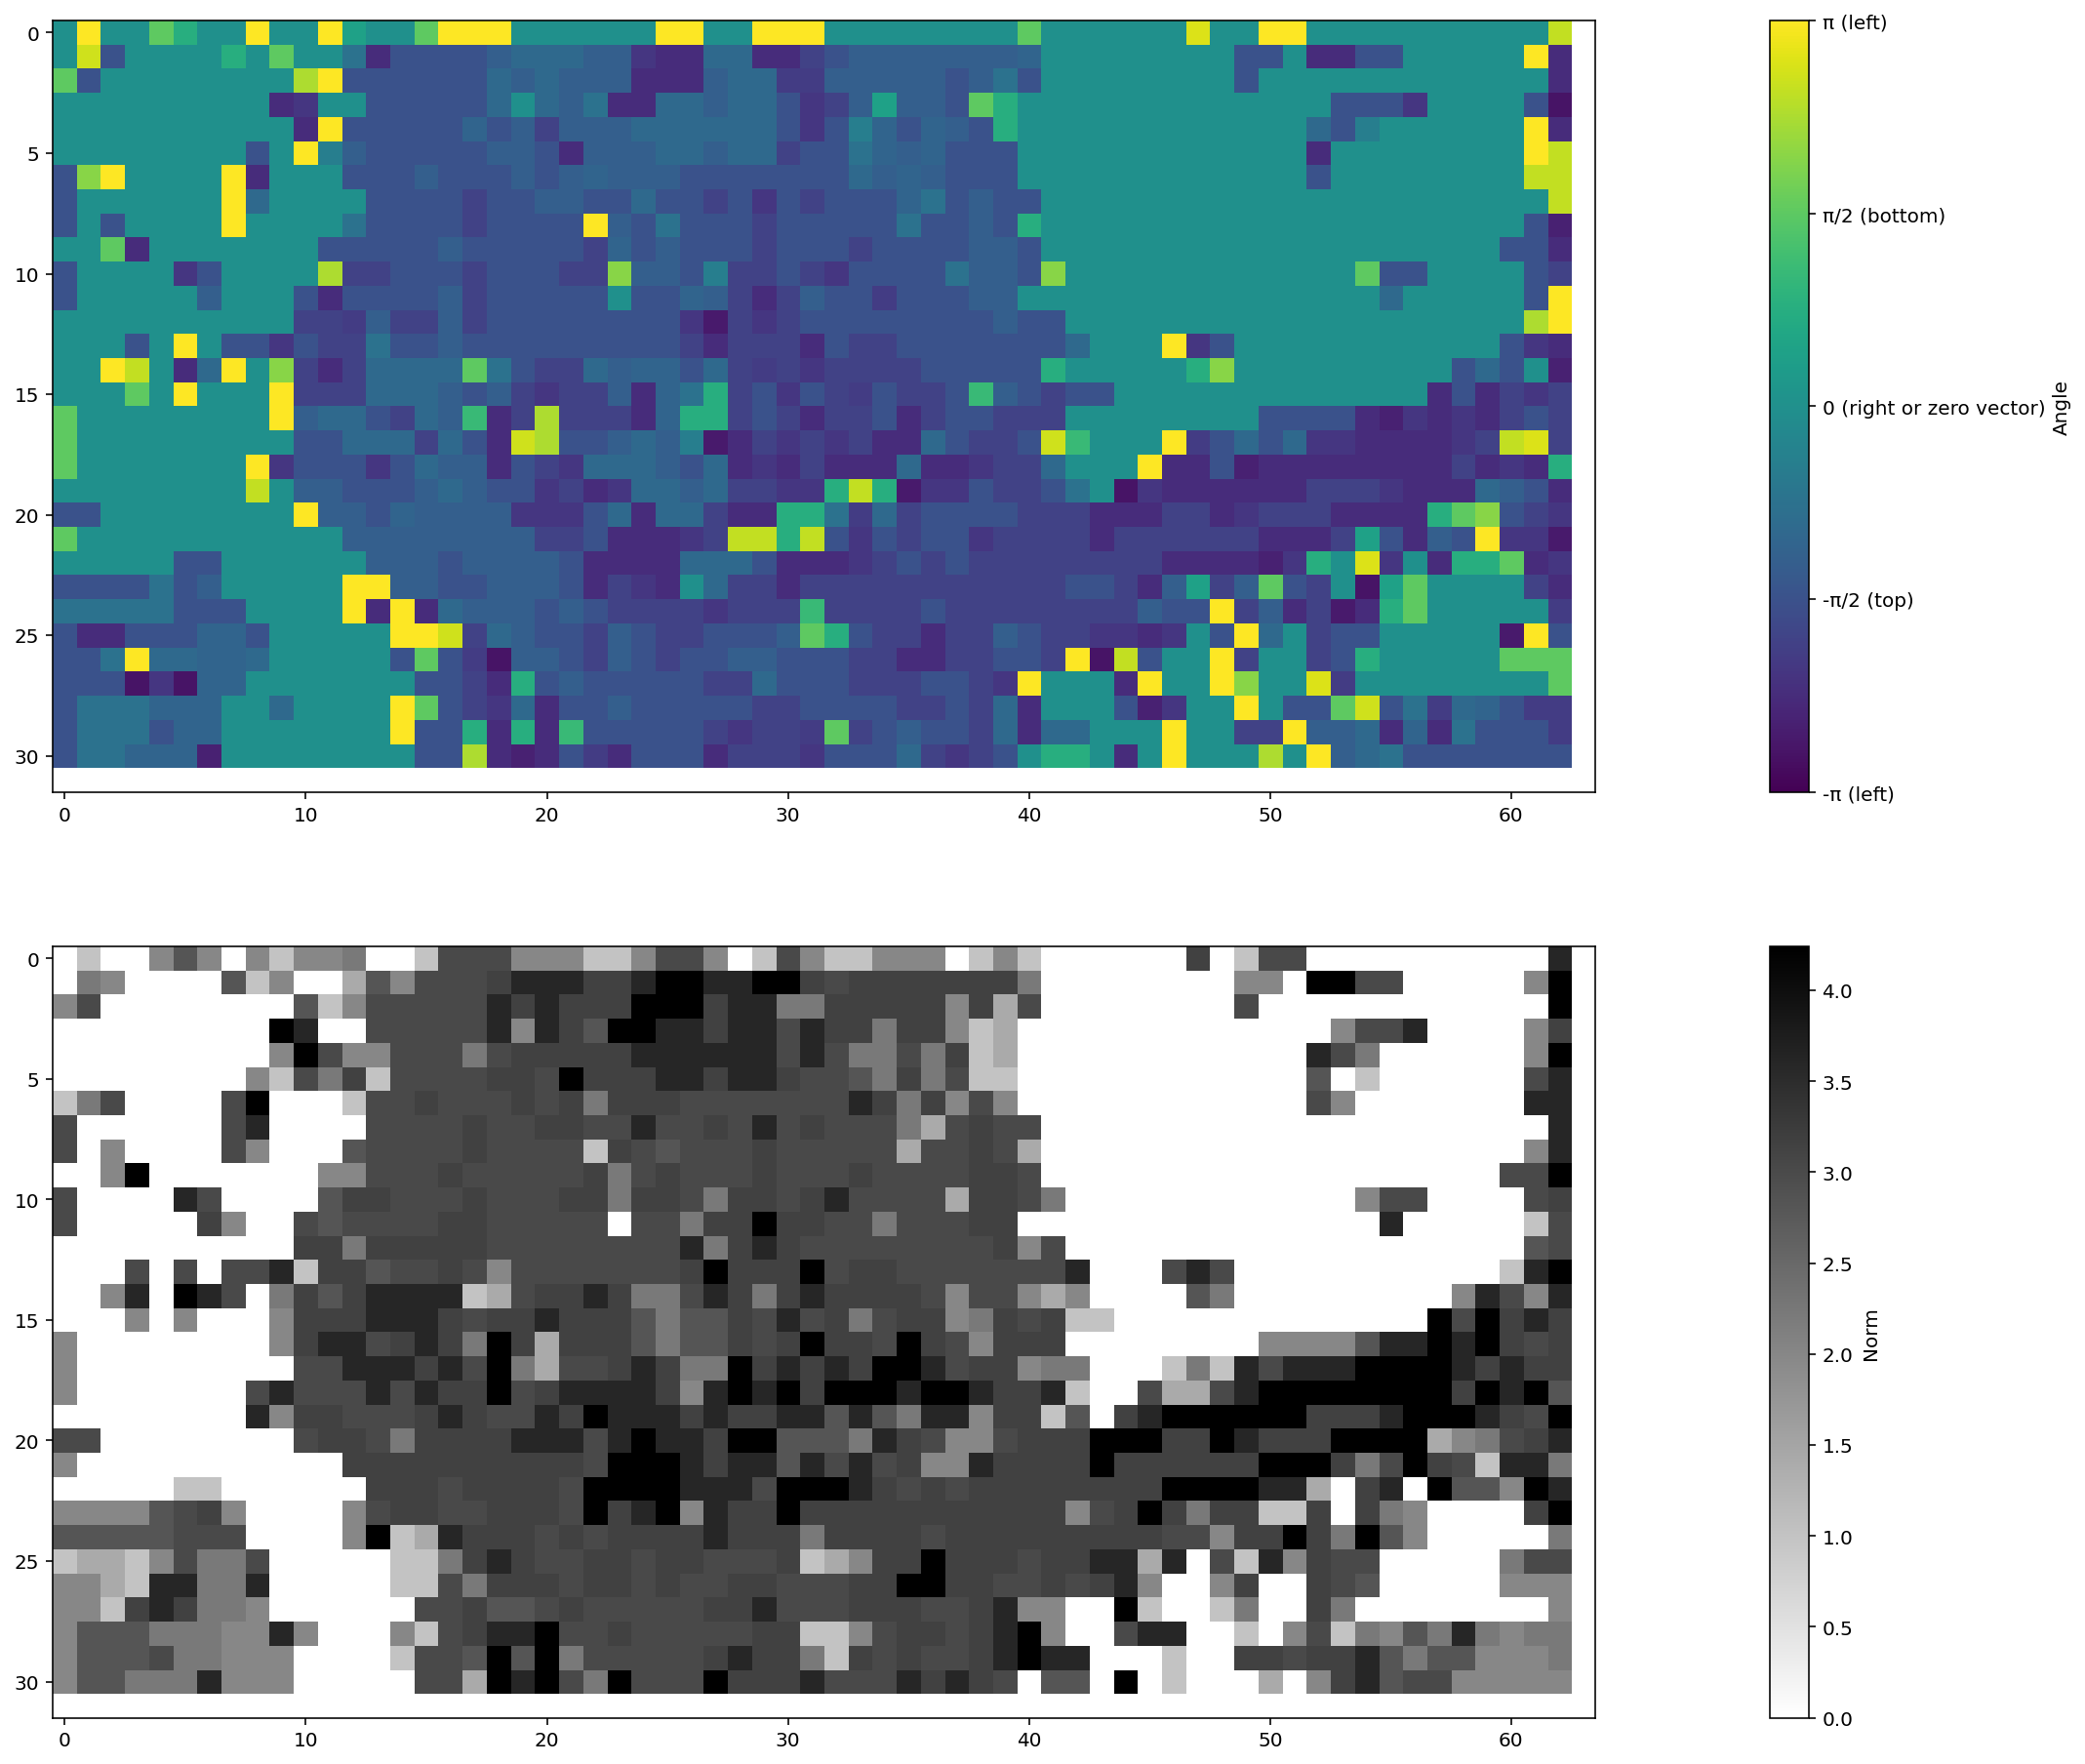

In [182]:
bma_imgs(0, 1, 10, 3)

(B) Sachant que l’on va vouloir reconstruire la frame F2 à partir de F1,
pourquoi a-t-on donc fait de la ME backward et pas de la ME forward ? Que
se serait-il passé sinon ? (pensez à quels artéfacts visuels on aurait obtenu)

*Nous voulons faire de la Motion Estimation backward car nous voulons reconstruire F2 à partir de F1. Si nous avions fait de la ME forward, nous aurions reconstruit F1 à partir de F2. Cela aurait donné des artéfacts visuels de type ghosting.*

(C) Reconstruisez l’image F2 à partir de vos vecteurs de mouvements et de
F1.

In [183]:
def reconstruct_frame2(frame1, motion_vectors, block_size):
    """
    Reconstruct frame 2 using frame 1 and the motion vectors
    """
    # Get the frame size
    height, width, _ = frame1.shape

    # Initialize the reconstructed frame
    frame2 = np.zeros((height, width, 3), dtype=np.float32)

    # Iterate over each IP in the current frame
    for a in trange(height):
        for b in range(width):
            # Get the motion vector for the current IP
            try:
                b_i, b_j = a // block_size, b // block_size
                u, v, _, _ = motion_vectors[b_i, b_j]

                # Calculate the new IP position
                # (If the IP is outside the frame, set it to the current IP)
                k, l = int(a + u), int(b + v)
                if k < 0 or k >= height or l < 0 or l >= width:
                    k, l = a, b

                # Set the current IP to the value of the IP in frame 1
                frame2[a, b] = frame1[k, l]
            except:
                frame2[a, b] = frame1[a, b]

    return frame2

In [184]:
def reconstructions_imgs(i, j, block_size, search_range):
    vectors = bma_block(images[i], images[j], block_size, search_range)
    
    reconstructed_img = reconstruct_frame2(images[i], vectors, block_size)
    plt.figure(figsize=(20, 20))
    plt.imshow(reconstructed_img)
    plt.show()

    return reconstructed_img

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

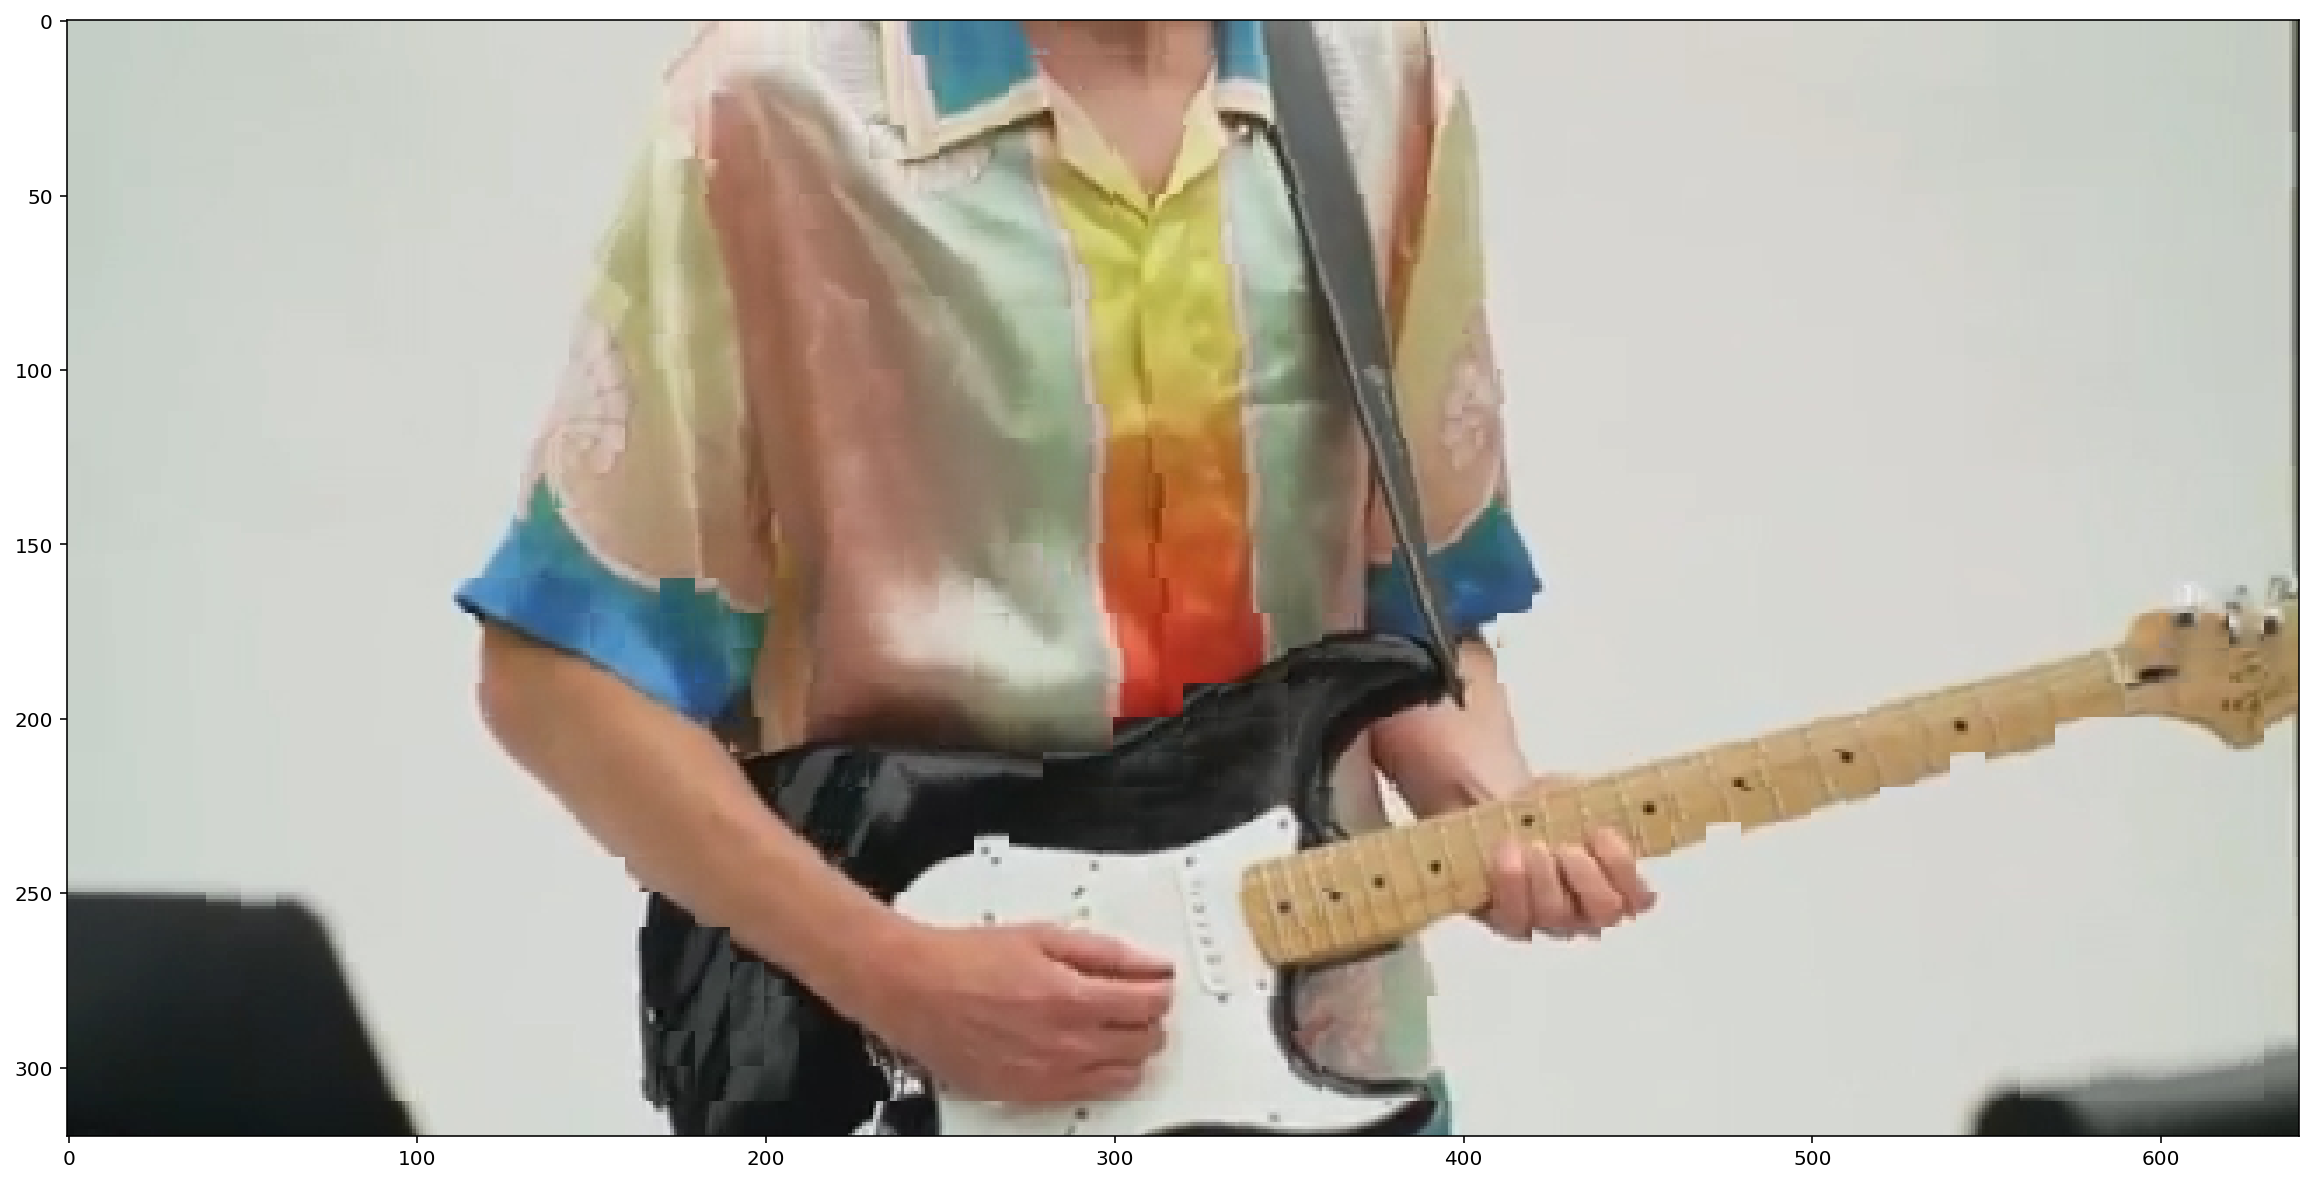

In [185]:
reconstructed_img = reconstructions_imgs(0, 1, 10, 3)

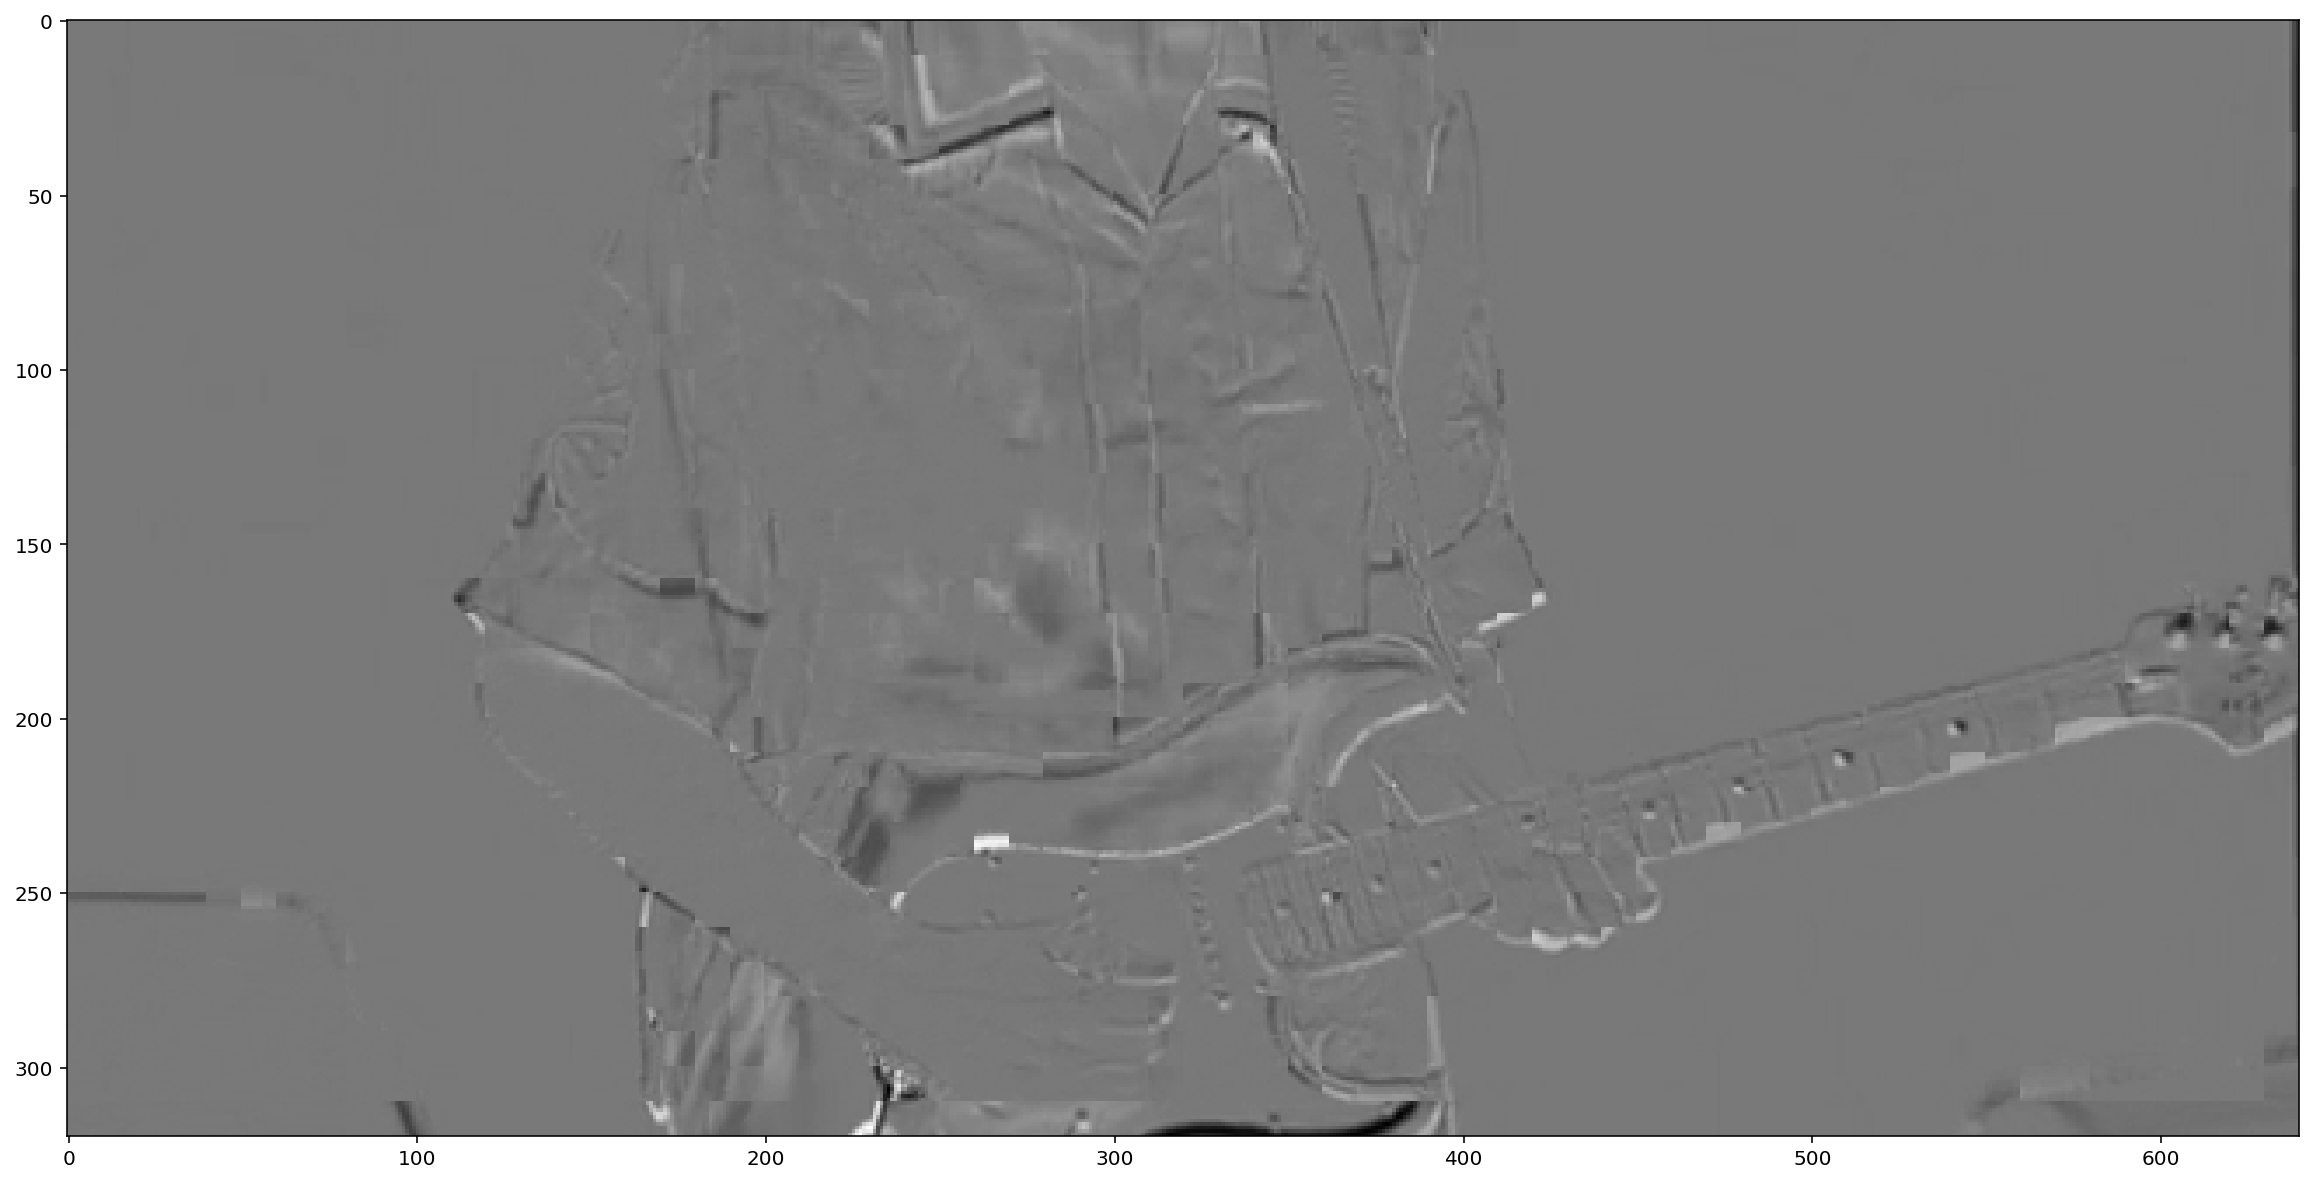

In [186]:
plt.figure(figsize=(20, 20))
plt.imshow(rgb2gray(reconstructed_img) - rgb2gray(images[1]), cmap='gray')
plt.show()

In [187]:
def frame_error(predicted_frame, real_frame):
    # Calculate the SNR
    return 10 * np.log10(np.sum(real_frame ** 2) \
                         / np.sum((real_frame - predicted_frame) ** 2))

In [188]:
print(frame_error(images[0], images[1]))
print(frame_error(reconstructed_img, images[1]))

18.794916273435902
22.897263309160284


In [189]:
def frame_error_mse(predicted_frame, real_frame):
    # Calculate the MSE
    return np.sum((real_frame - predicted_frame) ** 2) \
        / (real_frame.shape[0] * real_frame.shape[1])

Quelle est la MSE de reconstruction ?

In [190]:
print(frame_error_mse(images[0], images[1]))
print(frame_error_mse(reconstructed_img, images[1]))

0.019519305525519032
0.007589788228927442


(D) Supposant que l’on n’aura plus accès à F2, quelles sont les 3 données
”classiques” (en plus du paramètres de taille de bloc) dont on a besoin pour la
reconstruire de façon parfaite en compensation de mouvement ?
*Il nous faut les vecteurs de mouvement, la MSE de reconstruction et la frame de référence F1.*

(E) Reconstruisez F2 à partir de ces 3 données. Quelle est désormais la MSE
de reconstruction ?

In [191]:
import numpy as np

def reconstruct_frame2_with_residual(frame1, motion_vectors, residual, block_size):
    """
    Reconstruct frame 2 using frame 1 and the motion vectors
    """
    # Get the frame size
    height, width, _ = frame1.shape

    # Initialize the reconstructed frame
    frame2 = np.zeros((height, width, 3), dtype=np.float32)

    # Iterate over each IP in the current frame
    for a in trange(height):
        for b in range(width):
            # Get the motion vector for the current IP
            try:
                b_i, b_j = a // block_size, b // block_size
                u, v, _, _ = motion_vectors[b_i, b_j]

                # Calculate the new IP position
                # (If the IP is outside the frame, set it to the current IP)
                k, l = int(a + u), int(b + v)
                if k < 0 or k >= height or l < 0 or l >= width:
                    k, l = a, b

                # Set the current IP to the value of the IP in frame 1
                frame2[a, b] = np.clip(frame1[k, l] + residual[a, b], 0.0, 1.0)
            except:
                frame2[a, b] = frame1[a, b]

    return frame2

In [192]:
def calculate_residual(F1, F2):
    """
    Calculate the residual (prediction error) for the entire frame.
    """
    # Get the dimensions of the images
    height, width, _ = F1.shape
    
    # Create an array to store the residual for each pixel
    residual = np.zeros((height, width, 3))
    
    # Iterate over the entire frame
    for a in trange(height):
        for b in range(width):
            residual[a, b] = F2[a, b] - F1[a, b]

    return residual

In [195]:
def reconstructions_imgs(i, j, block_size, search_range):
    vectors = bma_block(images[i], images[j], block_size, search_range)
    predicted = reconstruct_frame2(images[i], vectors, block_size)
    residual = calculate_residual(predicted, images[j])
    
    reconstructed_img =\
          reconstruct_frame2_with_residual(images[i], vectors, residual, block_size)
    plt.figure(figsize=(20, 20))
    plt.imshow(reconstructed_img)
    plt.show()

    return reconstructed_img

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

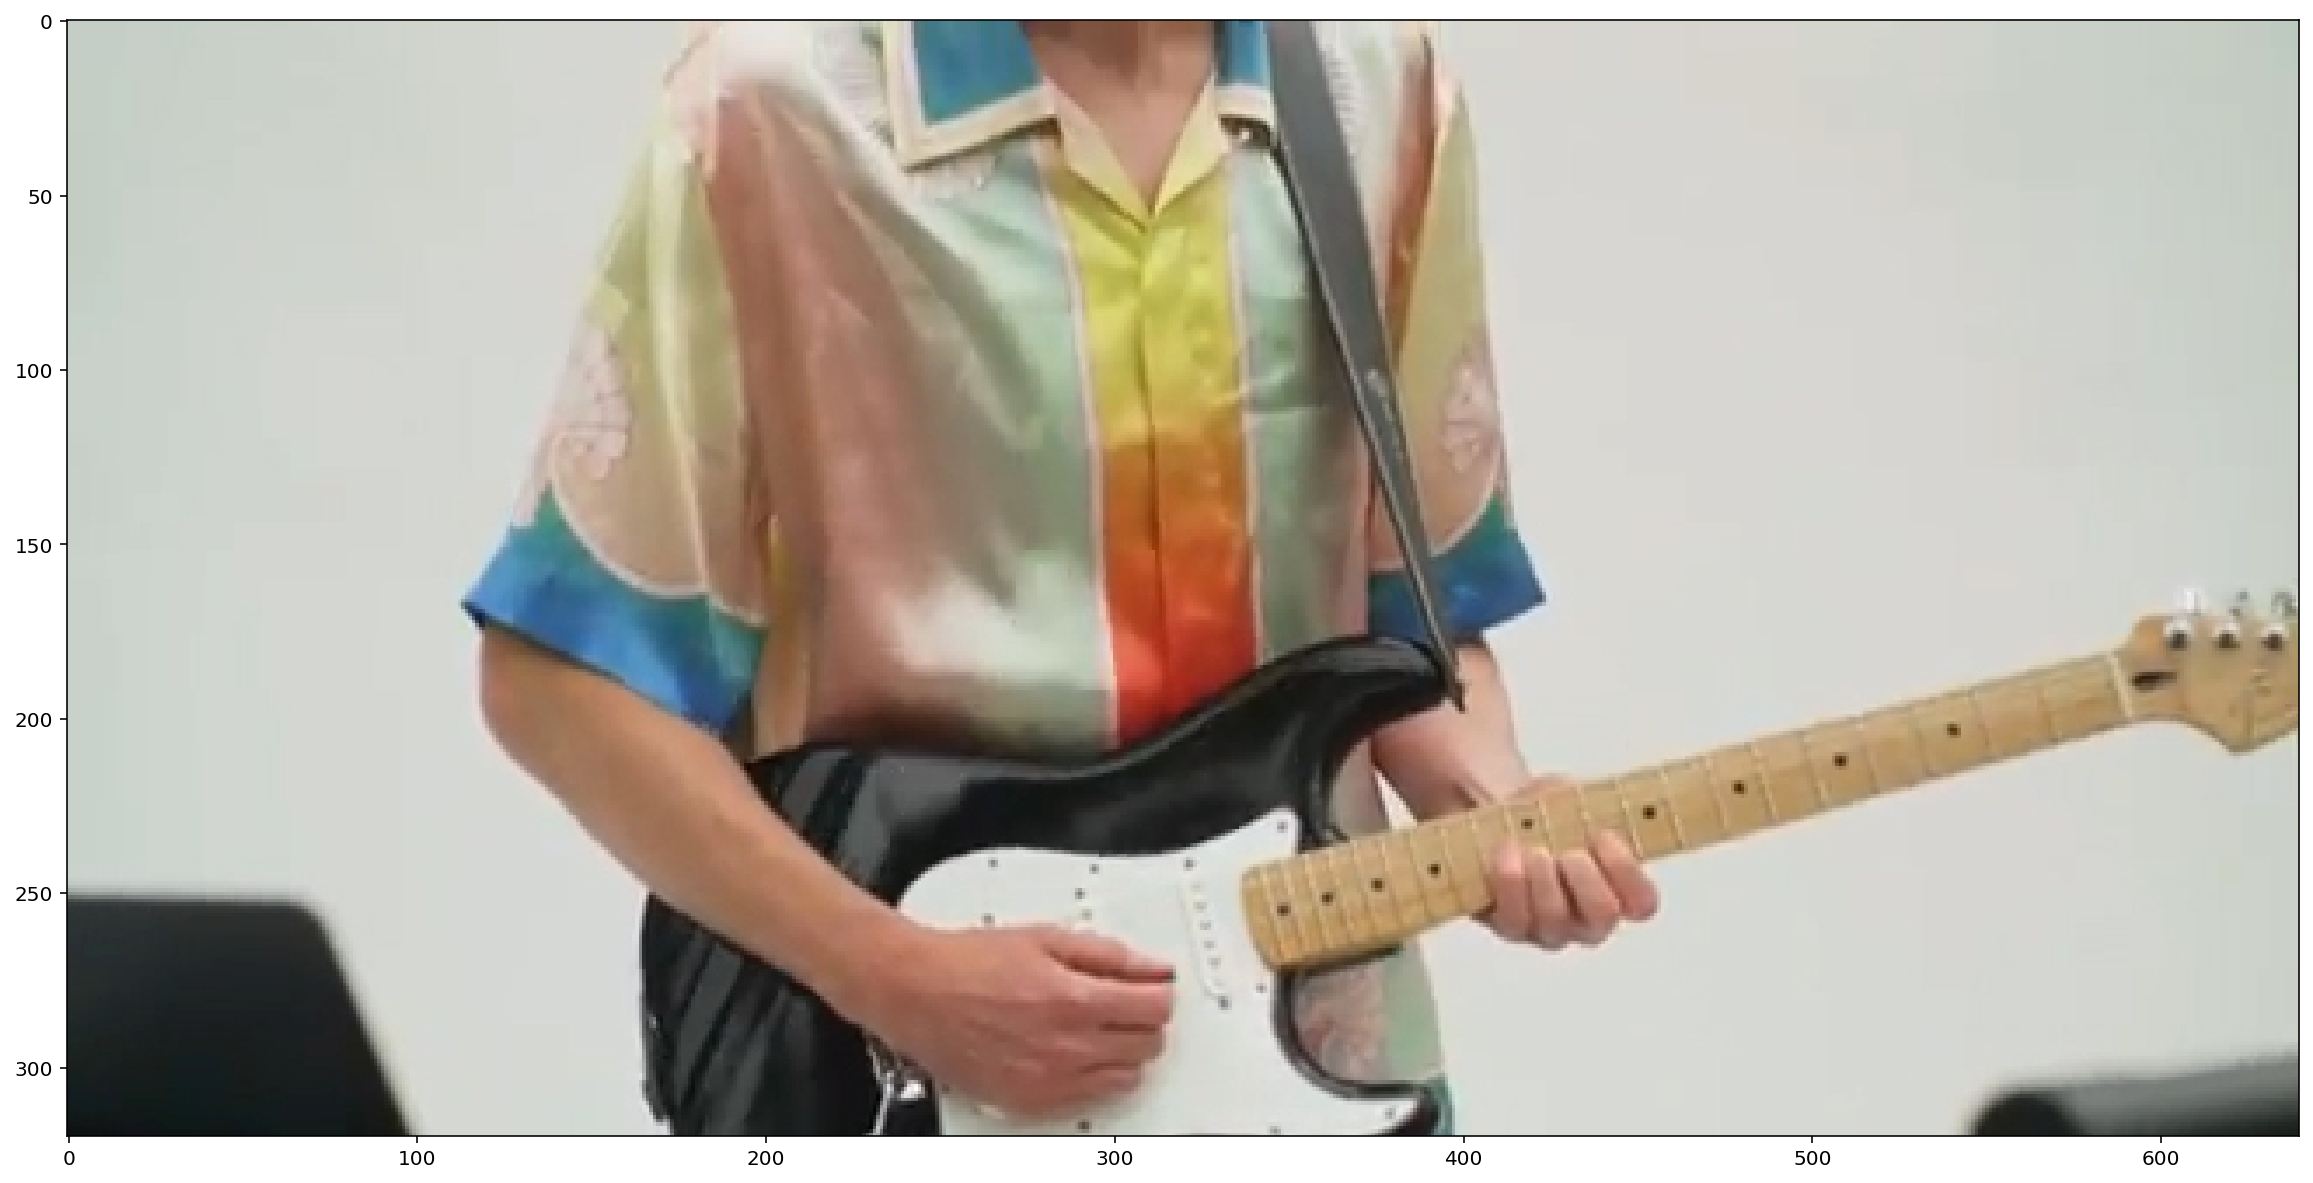

In [196]:
reconstructed_img = reconstructions_imgs(0, 1, 5, 3)

In [197]:
print(frame_error_mse(images[0], images[1]))
print(frame_error_mse(reconstructed_img, images[1]))

0.019519305525519032
1.0275242137156824e-15


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


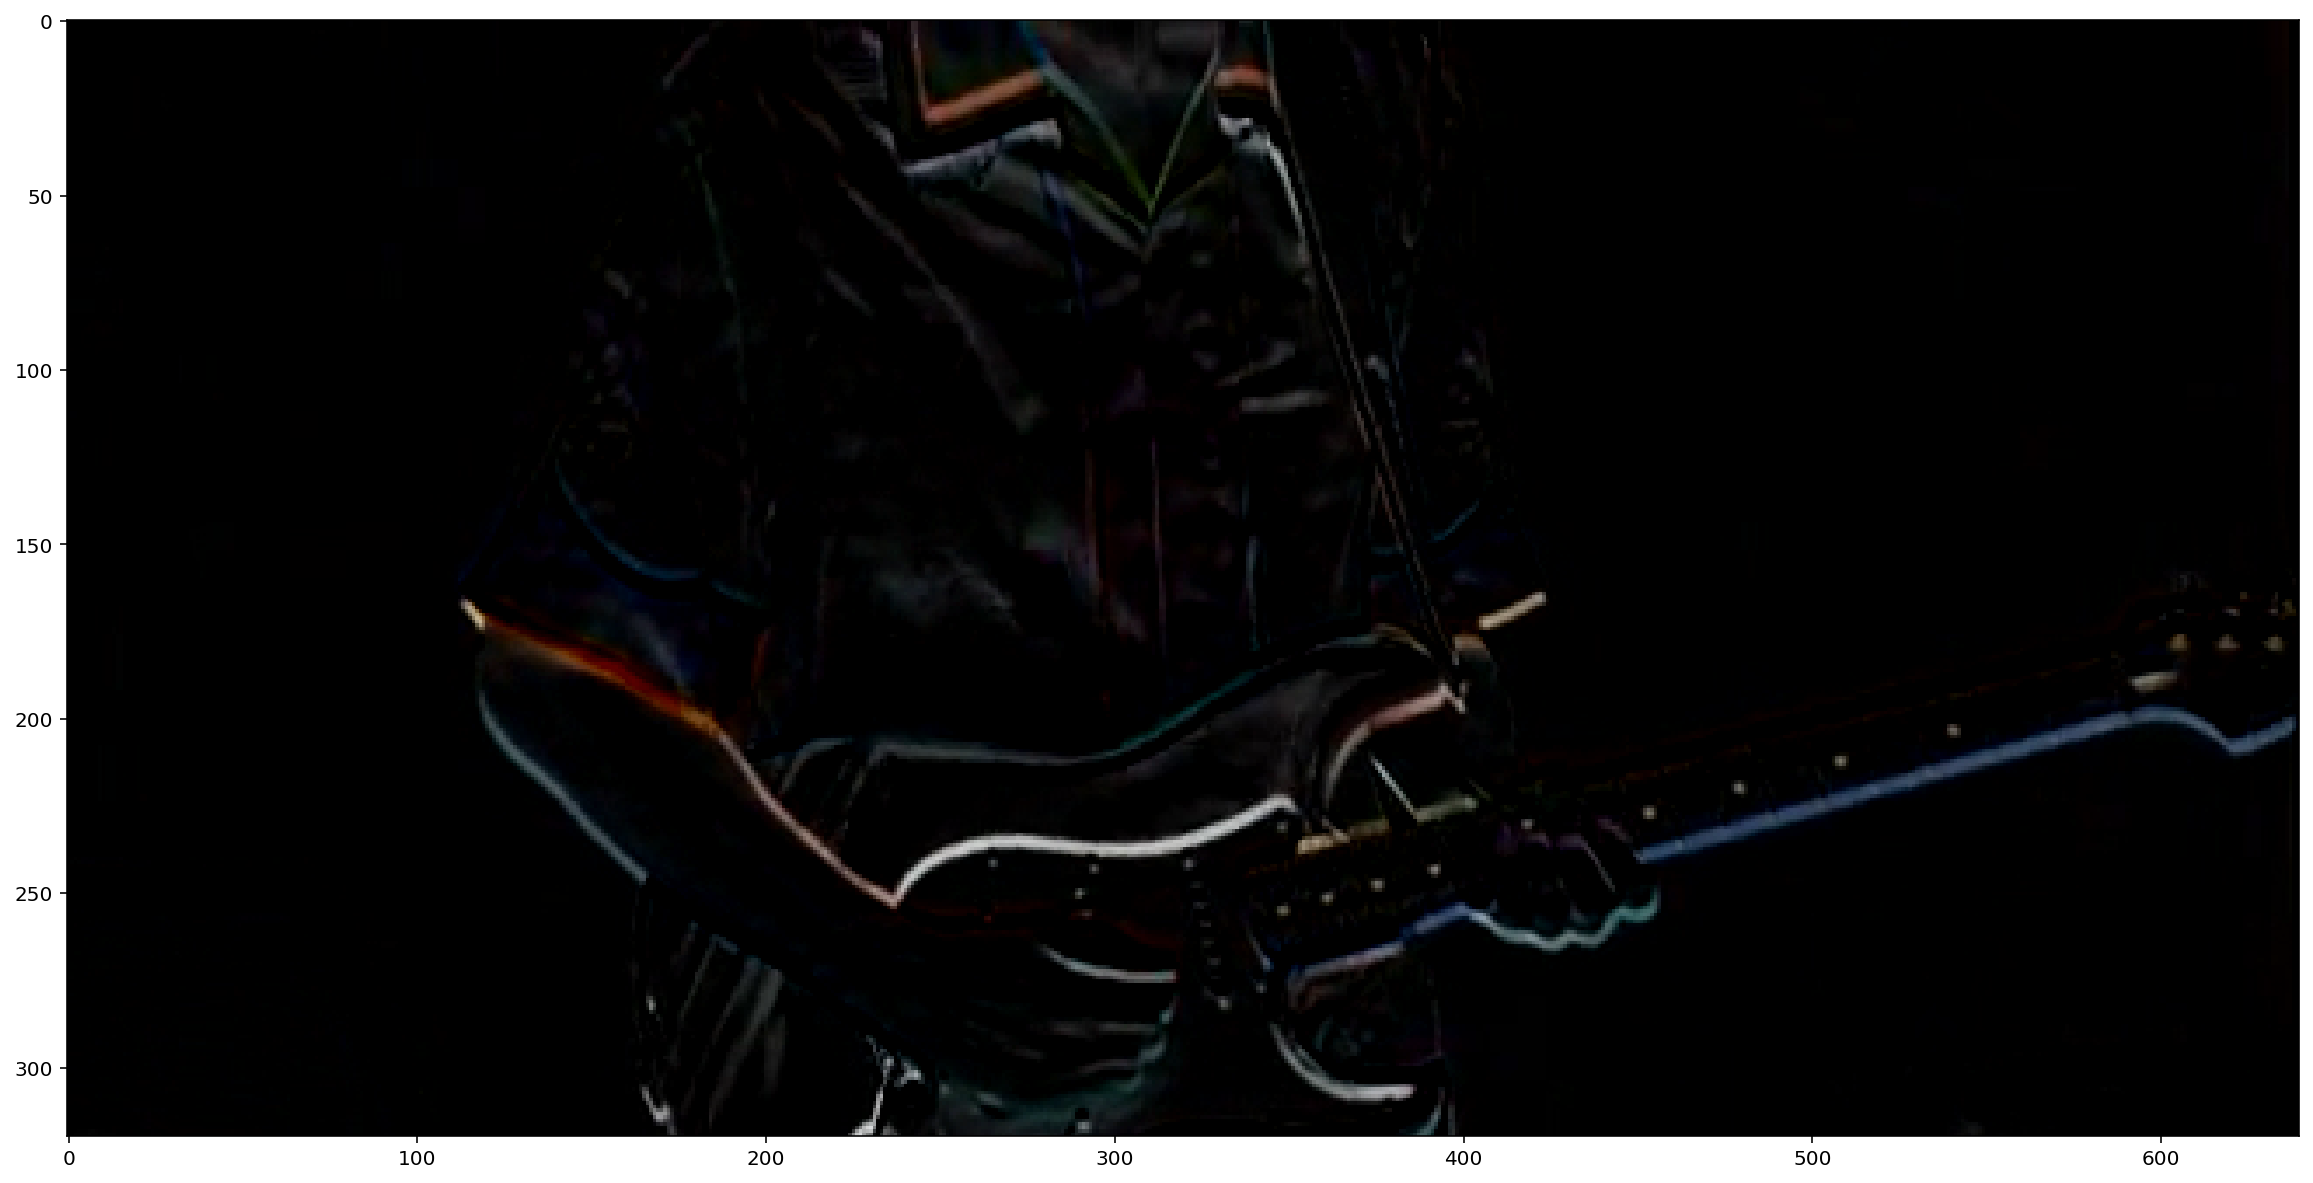

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


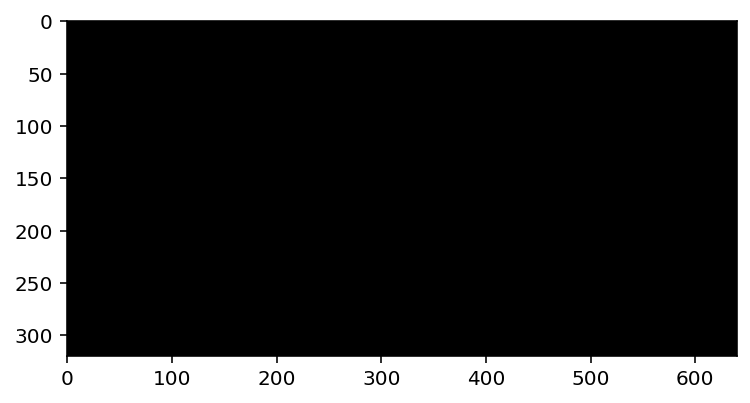

In [198]:
plt.figure(figsize=(20, 20))
plt.imshow(images[0] - images[1], cmap='gray')
plt.show()

plt.imshow(reconstructed_img - images[1], cmap='gray')
plt.show()

(F) Expliquez quelles données on peut coder avec perte pour garder une qualité de reconstruction de F1 et F2 ”correcte”. Justifiez vos explications par des images de rendus

*On peut coder avec perte les vecteurs de mouvement et le résidu. Ils peuvent être quantifiés en réduisant leur précision (ex : float64 -> int8). Cela peut être réalisé en les arrondissant à des valeurs plus grossières.*

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

Memory usage of one frame in MB :  4.6875
Memory usage by the data ({vectors.dtype}) in MB before :  4.8125
Memory usage by the data ({vectors.dtype}) in MB after :  1.234375


  0%|          | 0/320 [00:00<?, ?it/s]

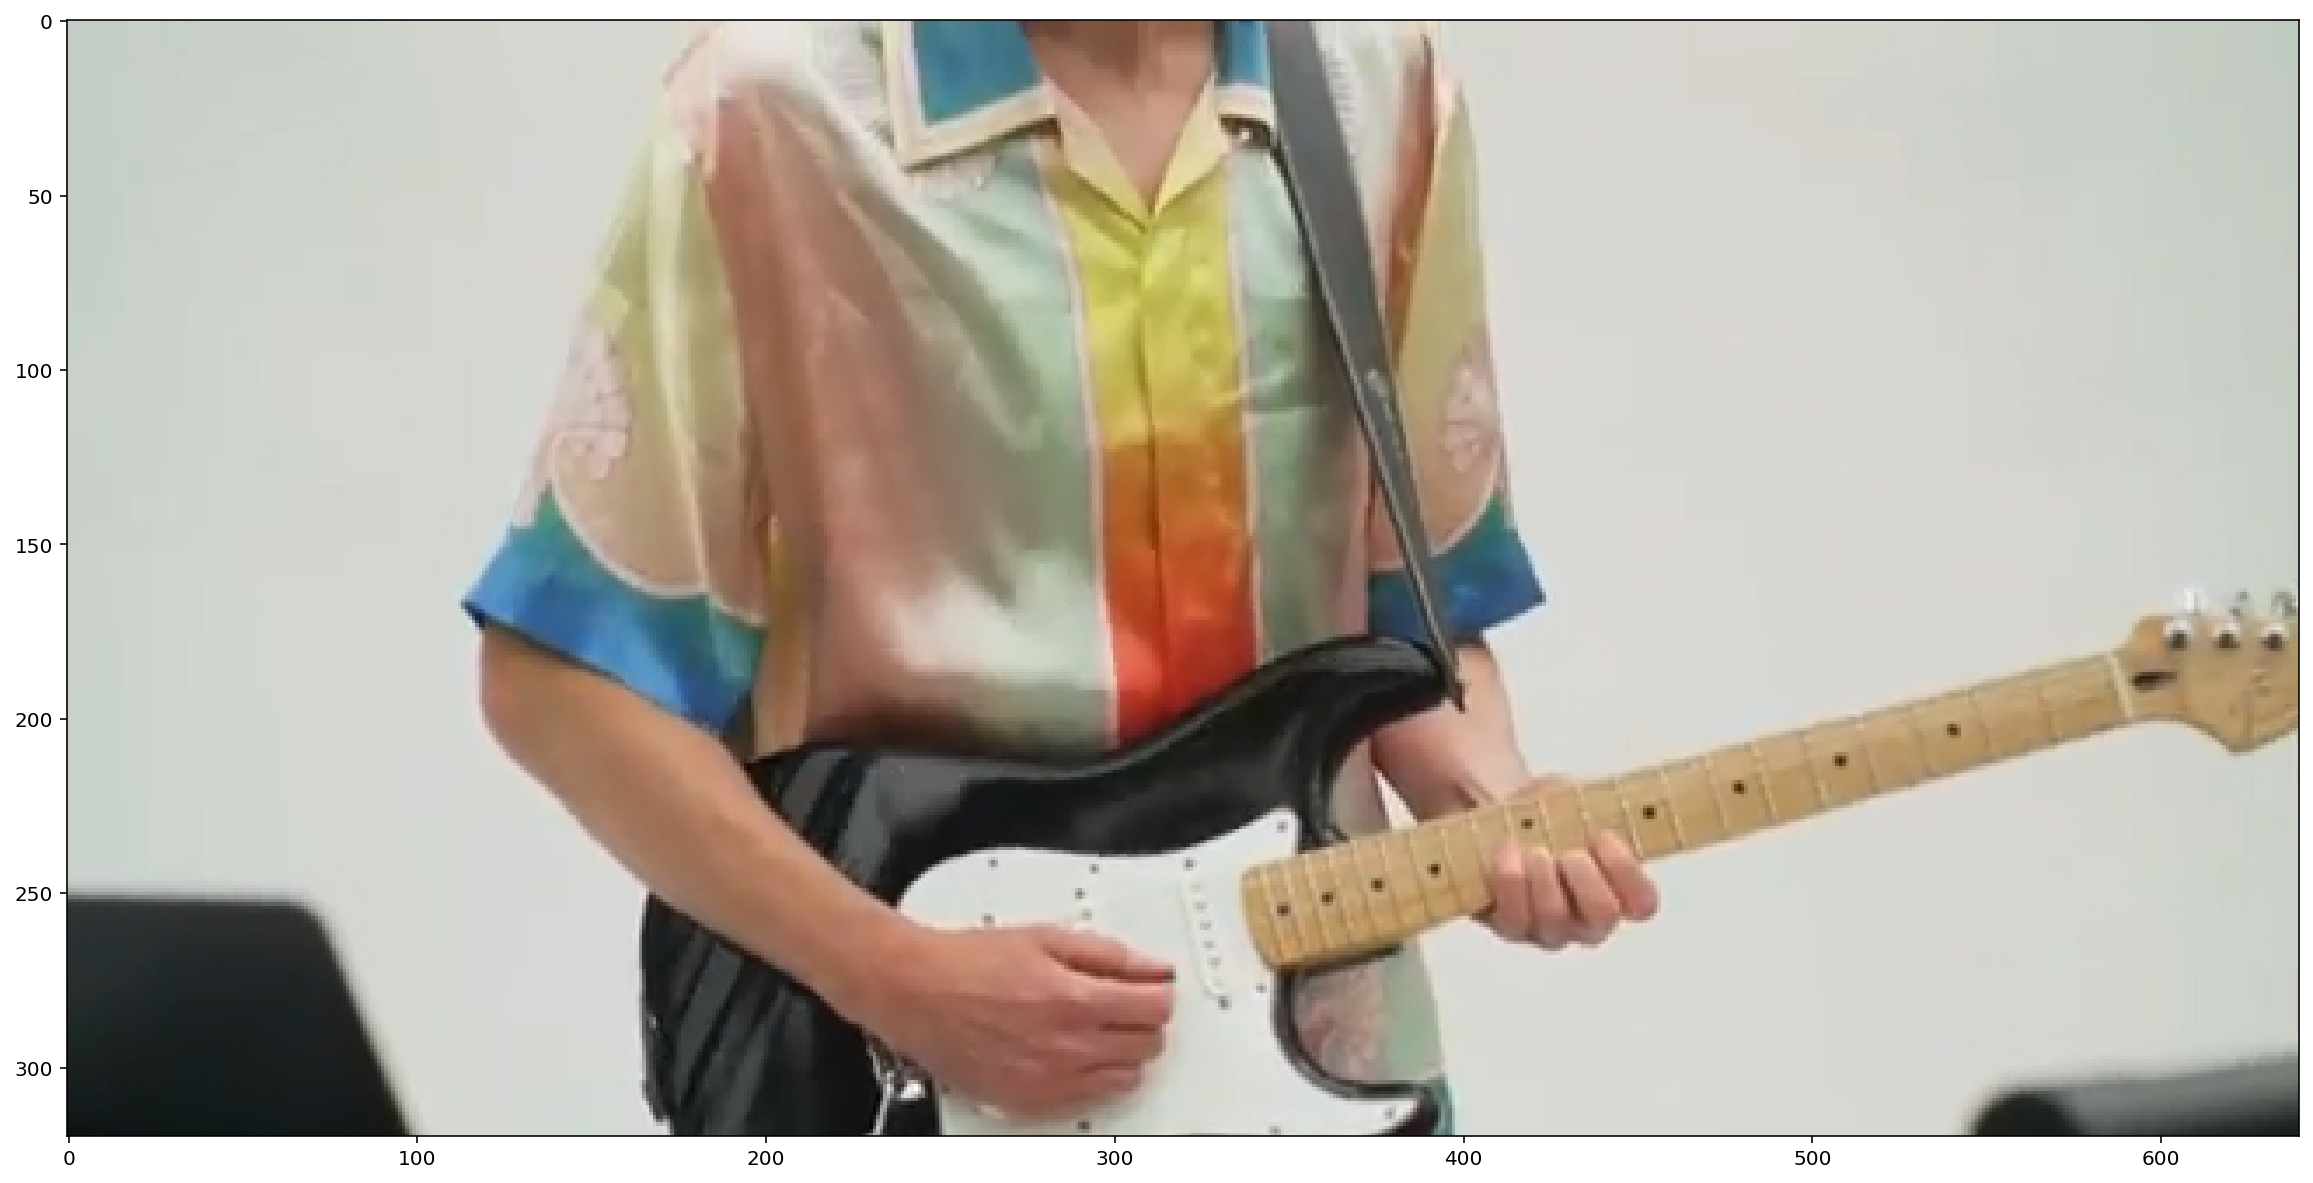

Native frame error MSE : 0.019519305525519032
Non compressed reconstructed frame error MSE : 1.0275242137156824e-15
Compressed reconstructed frame error MSE : 2.9987603620735765e-10


In [199]:
import pandas as pd
def reconstructions_imgs_2(i, j, block_size, search_range):
    vectors = bma_block(images[i], images[j], block_size, search_range)

    predicted = reconstruct_frame2(images[i], vectors, block_size)
    residual = calculate_residual(predicted, images[j])

    print("Memory usage of one frame in MB : ", images[i].nbytes / 1024 / 1024)
    print("Memory usage by the data ({vectors.dtype}) in MB before : ",\
           (vectors.nbytes + residual.nbytes) / 1024 / 1024)

    # quantize by converting to int8
    vectors = vectors.astype(np.float16)
    residual = residual.astype(np.float16)
    print("Memory usage by the data ({vectors.dtype}) in MB after : ",\
           (vectors.nbytes + residual.nbytes) / 1024 / 1024)

    r = reconstruct_frame2_with_residual(images[i], vectors, residual, block_size)
    plt.figure(figsize=(20, 20))
    plt.imshow(r)
    plt.show()

    return r

reconstructed_img_2 = reconstructions_imgs_2(0, 1, 5, 3)
print(f"Native frame error MSE : {frame_error_mse(images[0], images[1])}")
print(f"Non compressed reconstructed frame error MSE : \
      {frame_error_mse(reconstructed_img, images[1])}")
print(f"Compressed reconstructed frame error MSE : \
      {frame_error_mse(reconstructed_img_2, images[1])}")

(G) Qu’est-ce-qui aurait changé si on utilise une méthode à base de mesh du
point de vue de la minimisation ? et du point de vue du rendu final ? Montrez
vos résultats en vous aidant du TP1.

*Une méthode basée sur des maillages peut offrir de meilleurs résultats en termes de qualité d'image et de représentation des mouvements, en particulier pour des séquences avec des mouvements complexes. Cependant, elle peut être plus complexe en termes de calcul. Les méthodes basées sur des blocs, quant à elles, sont généralement plus simples et plus rapides, mais peuvent produire des artefacts de blocs et être moins précises dans la représentation des mouvements.*

In [200]:
# Load the images from the directory and normalize them
images2 = []
for filename in glob.glob('images2/*.png'):
    images2.append(np.asarray(image.imread(filename)))

Let's import the mesh based algorithm from the previous TP.

  0%|          | 0/20 [00:00<?, ?it/s]

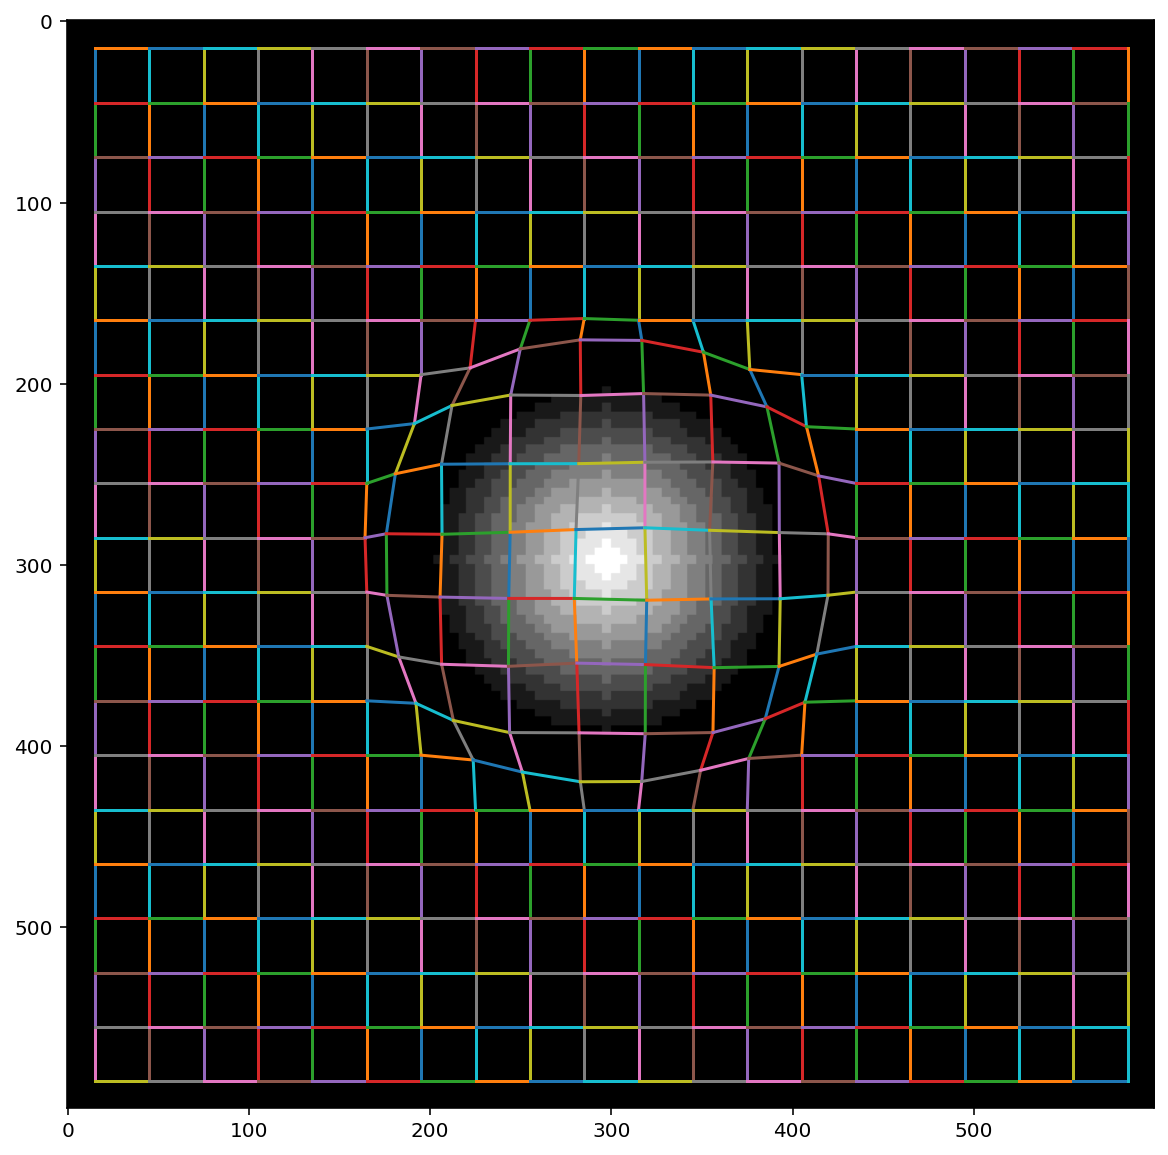

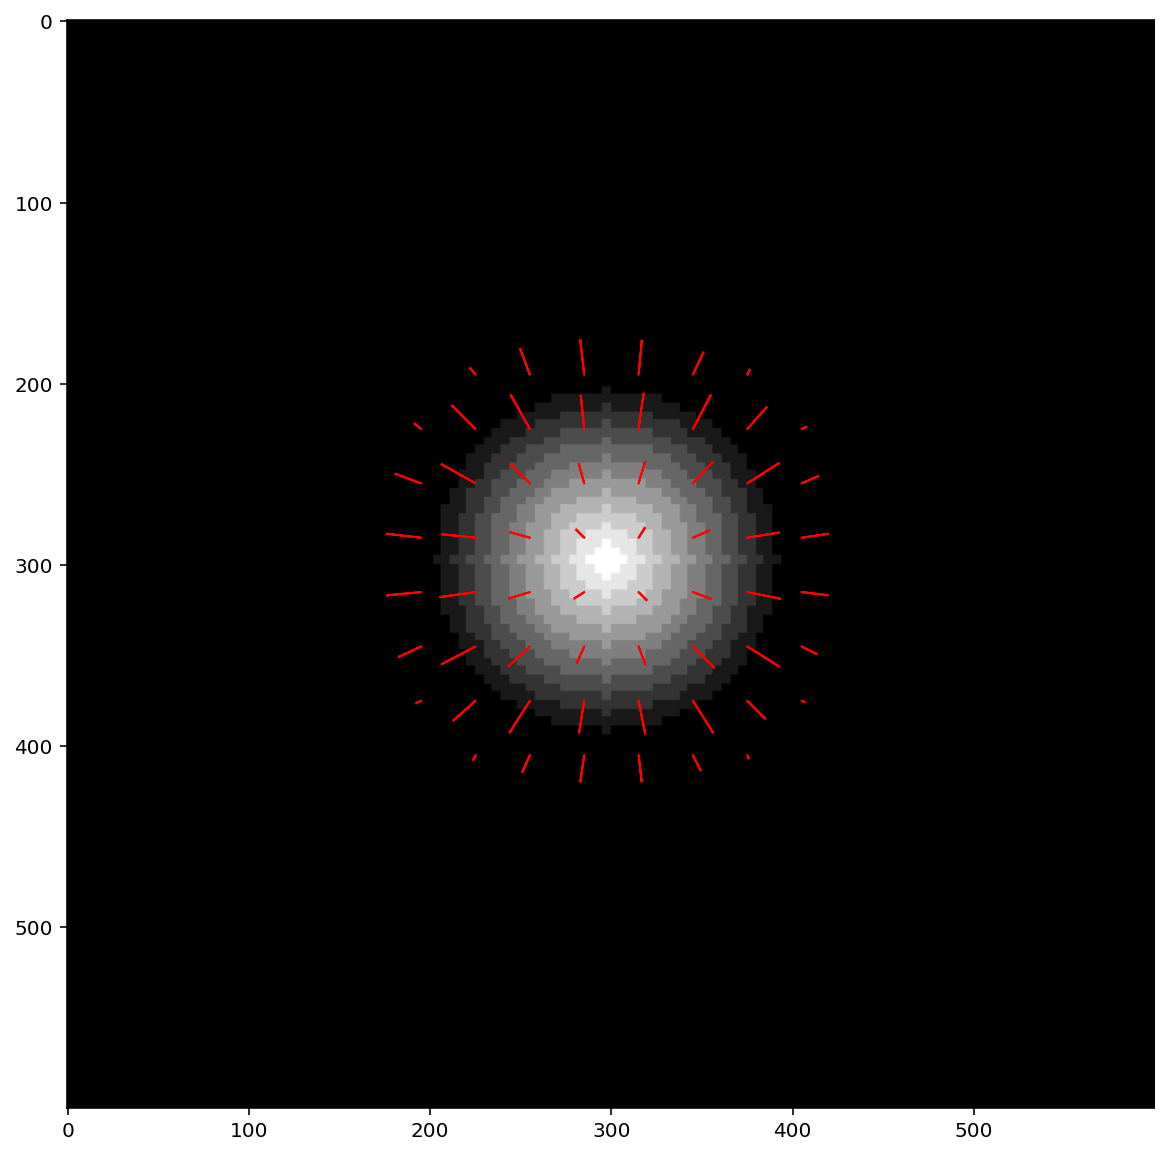

In [201]:
# Function to compute the sum of squared differences between two frames given a node and its displacements
def compute_dfd(frame1, frame2, node, displacements, nx, ny):
    i, j = node
    width, height = frame1.shape

    # Calculate the region in the frame corresponding to the node
    xmin = int(i * width / nx)
    ymin = int(j * height / ny)
    xmax = int((i + 1) * width / nx)
    ymax = int((j + 1) * height / ny)

    # Ensure the region coordinates are within the frame boundaries
    xmin = max(xmin, 0)
    ymin = max(ymin, 0)
    xmax = min(xmax, frame1.shape[0])
    ymax = min(ymax, frame1.shape[1])

    d = displacements

    x = np.arange(xmin, xmax)
    y = np.arange(ymin, ymax)

    # Create a meshgrid for the block coordinates
    xx, yy = np.meshgrid(x, y, indexing='ij')

    d_int = np.round(d).astype(np.int32)

    # Compute the new coordinates after applying the displacements
    x_new = np.clip(xx + d_int[0], 0, frame2.shape[0] - 1)
    y_new = np.clip(yy + d_int[1], 0, frame2.shape[1] - 1)

    # Calculate the sum of squared differences
    E_d = np.sum((frame2[x_new, y_new] - frame1[xx, yy]) ** 2)

    return E_d

# Function to compute the gradient of the sum of squared differences
def compute_gradient(frame1, frame2, node, displacements, eps, nx, ny):
    gradient = np.zeros_like(displacements)
    for i in range(2):
        e = np.zeros_like(displacements)
        e[i] = 1
        grad = compute_dfd(frame1, frame2, node, displacements + e * eps, nx, ny) - \
            compute_dfd(frame1, frame2, node, displacements, nx, ny)
        gradient[i] = grad / eps

    return gradient

# Function to perform gradient descent on the mesh
def gradient_descent_mesh(frame1, frame2, iterations=200, lr=0.1, nx=4, ny=4):
    displacements = np.zeros((nx, ny, 2), dtype=np.float32)

    for _ in range(iterations):
        for i in range(nx):
            for j in range(ny):
                node = (i, j)
                gradient = \
                    compute_gradient(frame1, frame2, node, displacements[i, j], 2, nx, ny)
                displacements[i, j] -= lr * gradient

    return displacements

# Function to displace the mesh using the calculated displacements
def displace_mesh(frame1, frame2, nx=4, ny=4, lr=0.1):
    height, width = frame1.shape
    mesh_grid = np.zeros((height, width), dtype=frame1.dtype)

    displacements = gradient_descent_mesh(frame1, frame2, nx=nx, ny=ny, lr=lr)

    for i in trange(nx):
        for j in range(ny):
            displacements_node = displacements[i, j]

            # Calculate the corresponding region in the frame
            xmin = int(i * width / nx)
            ymin = int(j * height / ny)
            xmax = int((i + 1) * width / nx)
            ymax = int((j + 1) * height / ny)

            if xmin == xmax or ymin == ymax:
                continue

            x = np.arange(xmin, xmax)
            y = np.arange(ymin, ymax)
            xx, yy = np.meshgrid(x, y, indexing='ij')

            d_int = np.round(displacements_node).astype(np.int32)
            x_new = np.clip(xx + d_int[0], 0, frame2.shape[0] - 1)
            y_new = np.clip(yy + d_int[1], 0, frame2.shape[1] - 1)

            # Cette ligne provoque l'erreur
            mesh_grid[xmin:xmax, ymin:ymax] = frame1[x_new, y_new]


    return displacements

def display_mesh(frame, displacements):
    """
    Display the mesh with the displacements
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(frame, cmap='gray')

    height, width = frame.shape
    nx, ny = displacements.shape[:2]

    for i in range(nx):
        for j in range(ny):
            dx, dy = displacements[i, j]
            x = int(i * width / nx + width / (2 * nx))
            y = int(j * height / ny + height / (2 * ny))

            x_new = x + dx
            y_new = y + dy

            # Draw horizontal lines
            if j < ny - 1:
                dx_right, dy_right = displacements[i, j + 1]
                x_right = int(i * width / nx + width / (2 * nx))
                y_right = int((j + 1) * height / ny + height / (2 * ny))
                x_right_new = x_right + dx_right
                y_right_new = y_right + dy_right

                ax.plot([x_new, x_right_new], [y_new, y_right_new])

            # Draw vertical lines
            if i < nx - 1:
                dx_down, dy_down = displacements[i + 1, j]
                x_down = int((i + 1) * width / nx + width / (2 * nx))
                y_down = int(j * height / ny + height / (2 * ny))
                x_down_new = x_down + dx_down
                y_down_new = y_down + dy_down

                ax.plot([x_new, x_down_new], [y_new, y_down_new])

    plt.show()

def display_displacement_vectors(frame, displacements):
    """
    Display the displacement vectors on the frame
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(frame, cmap='gray')

    height, width = frame.shape
    nx, ny = displacements.shape[:2]

    for i in range(nx):
        for j in range(ny):
            dx, dy = displacements[i, j]
            x = int(i * width / nx + width / (2 * nx))
            y = int(j * height / ny + height / (2 * ny))

            if np.linalg.norm([dx, dy]) < 1:
                continue

            ax.arrow(x, y, dx, dy, color='red')

    plt.show()

block_div = 20
nx=block_div
ny=block_div

frame1 = rgb2gray(images2[0])
frame2 = rgb2gray(images2[1])

# Calculate the displacements
displacement_mesh = displace_mesh(frame1, frame2, nx, ny)
display_mesh(frame1, displacement_mesh)
display_displacement_vectors(frame1, displacement_mesh)

Let's write a function that takes the displacements calculated from the mesh based algorithm, and returns the reconstructed image.

In [202]:
def predict_frame_using_displacements(frame1, displacements, residuals=None, residuals_multiplier=1.0):
    if residuals is None:
        residuals = np.zeros_like(frame1)
    height, width, channels = frame1.shape
    predicted_frame = np.zeros((height, width, channels), dtype=frame1.dtype)
    nx, ny = displacements.shape[:2]

    for i in range(nx):
        for j in range(ny):
            displacements_node = displacements[i, j]

            # Calculate the corresponding region in the frame
            xmin = int(i * width / nx)
            ymin = int(j * height / ny)
            xmax = int((i + 1) * width / nx)
            ymax = int((j + 1) * height / ny)

            if xmin == xmax or ymin == ymax:
                continue

            x = np.arange(xmin, xmax)
            y = np.arange(ymin, ymax)
            xx, yy = np.meshgrid(x, y, indexing='ij')

            d_int = np.round(displacements_node).astype(np.int32)
            x_new = np.clip(xx - d_int[0], 0, frame1.shape[1] - 1)
            y_new = np.clip(yy - d_int[1], 0, frame1.shape[0] - 1)

            residual_arr = residuals[xmin:xmax, ymin:ymax].astype(np.float32)
            
            if residuals_multiplier != 1.0:
                residual_arr = \
                    (residual_arr - 127.0) * residuals_multiplier * 2
                predicted_frame[xmin:xmax, ymin:ymax] = \
                    np.clip(frame1[x_new, y_new] + residual_arr, 0.0, 1.0)
            else:
                predicted_frame[xmin:xmax, ymin:ymax] = \
                    frame1[x_new, y_new] + residual_arr.astype(np.float32)

    return predicted_frame

In [203]:
def display_frame(frame, title="Frame"):
    """
    Display the given frame with a title
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(frame, cmap='gray')
    ax.set_title(title)
    plt.show()

block_div = 20
nx = block_div
ny = block_div

frame1 = images2[0]
frame2 = images2[1]

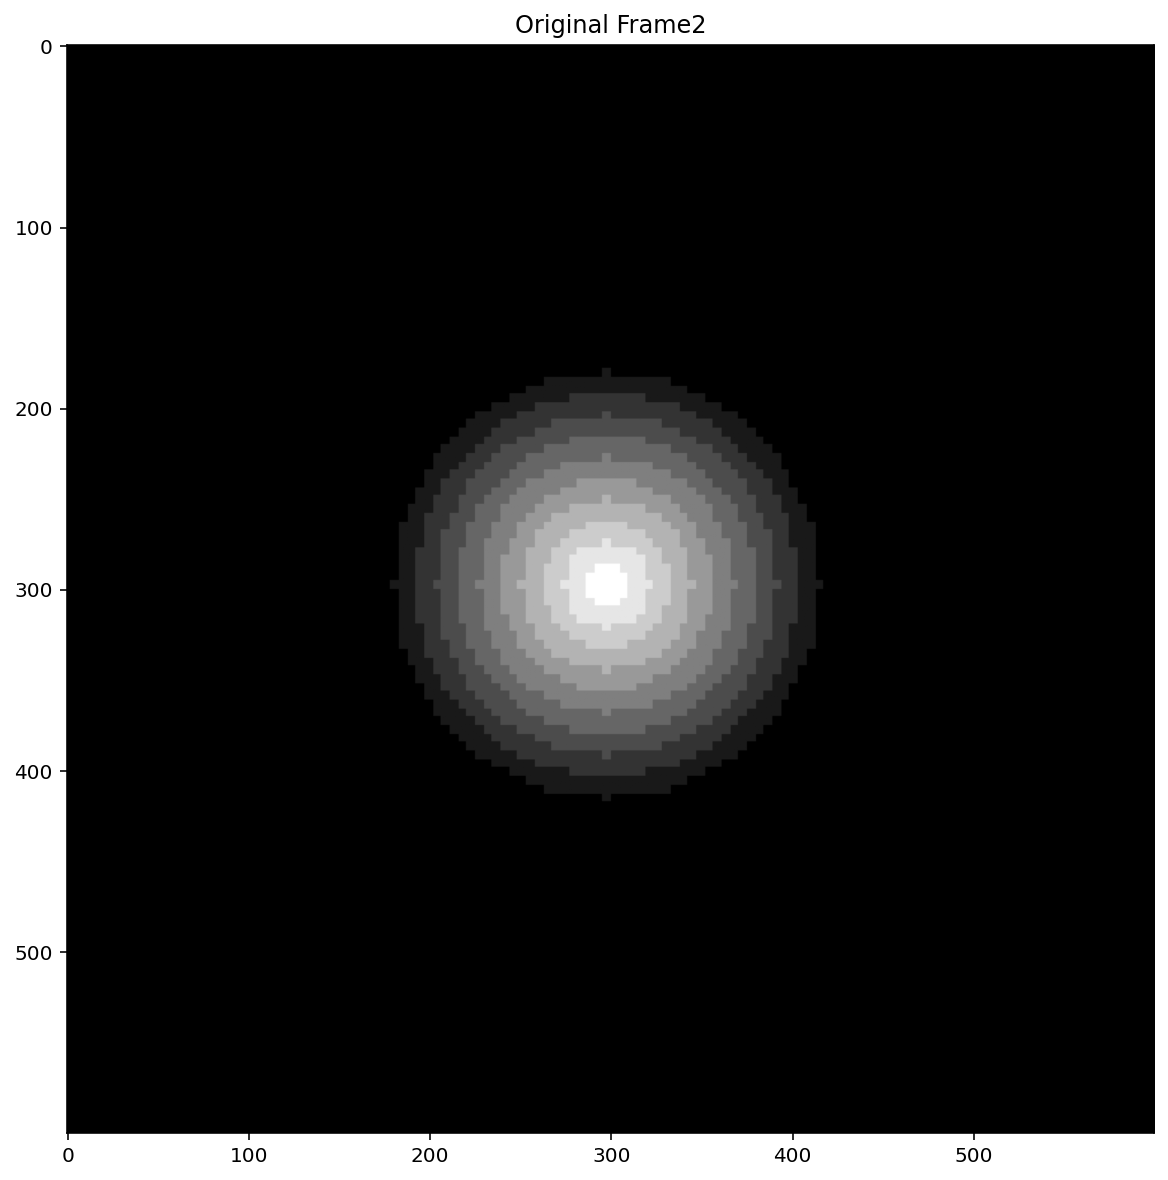

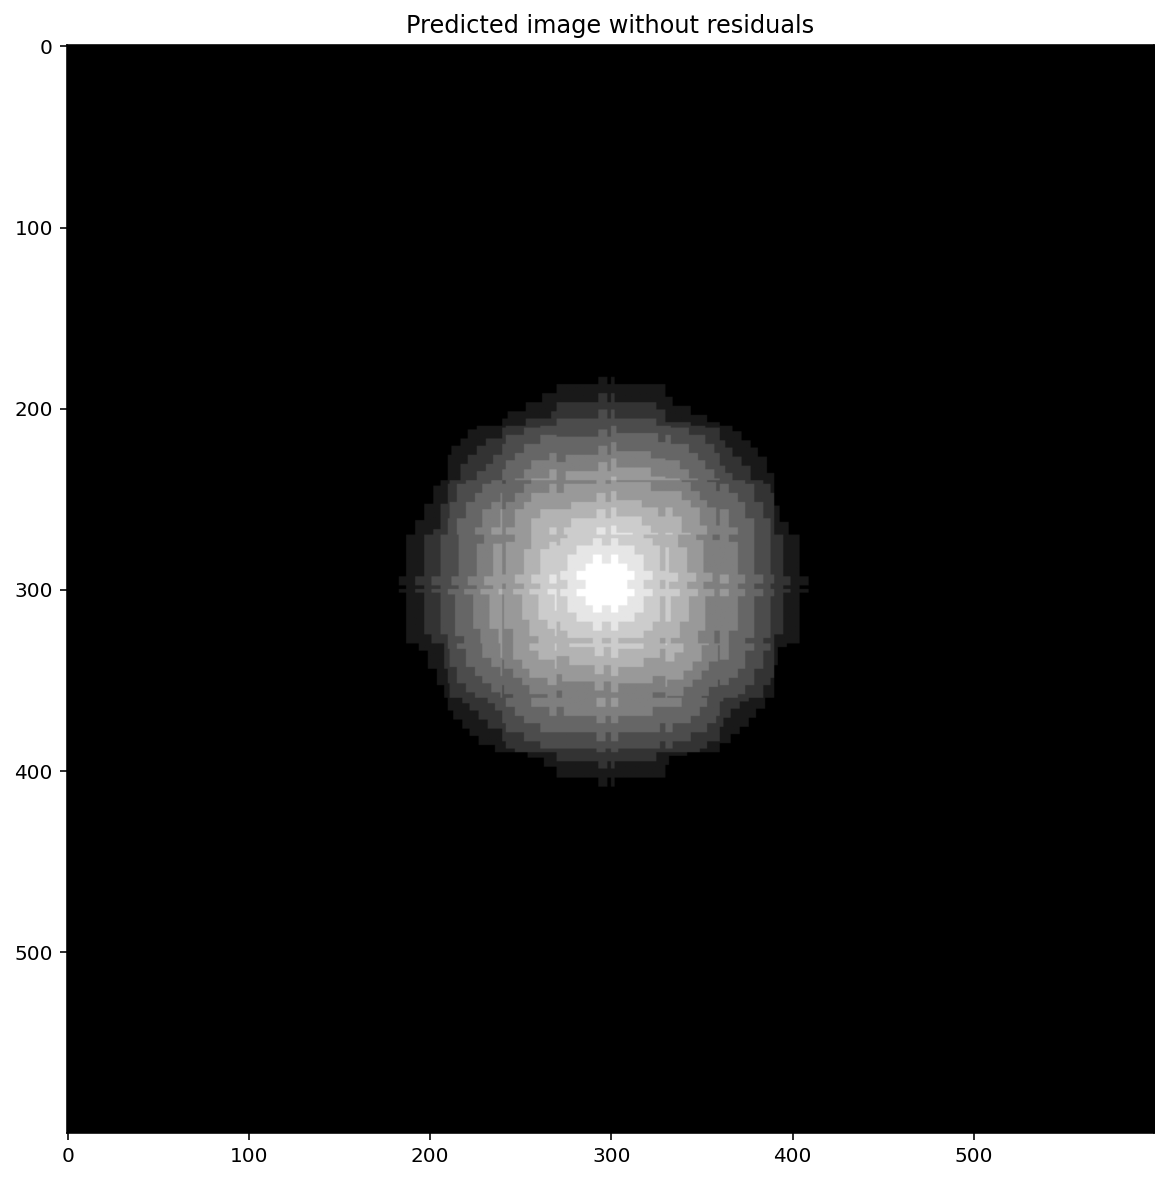

MSE: 0.0015550998263888889
PSNR: 16.977442502975464


In [204]:
display_frame(frame2, title="Original Frame2")

# Use the displacements to predict the frame 2 from frame 1 which will lead to prediction errors
predicted_image_non_residuals = \
    predict_frame_using_displacements(frame1, displacement_mesh)
display_frame(predicted_image_non_residuals, \
              "Predicted image without residuals")
print("MSE:", frame_error_mse(frame2, predicted_image_non_residuals))
print("PSNR:", frame_error(frame2, predicted_image_non_residuals))

Size of residuals float32: 4.12 MB
-0.20392159 0.2
0.0 252.54807
Size of residuals uint8: 1.03 MB


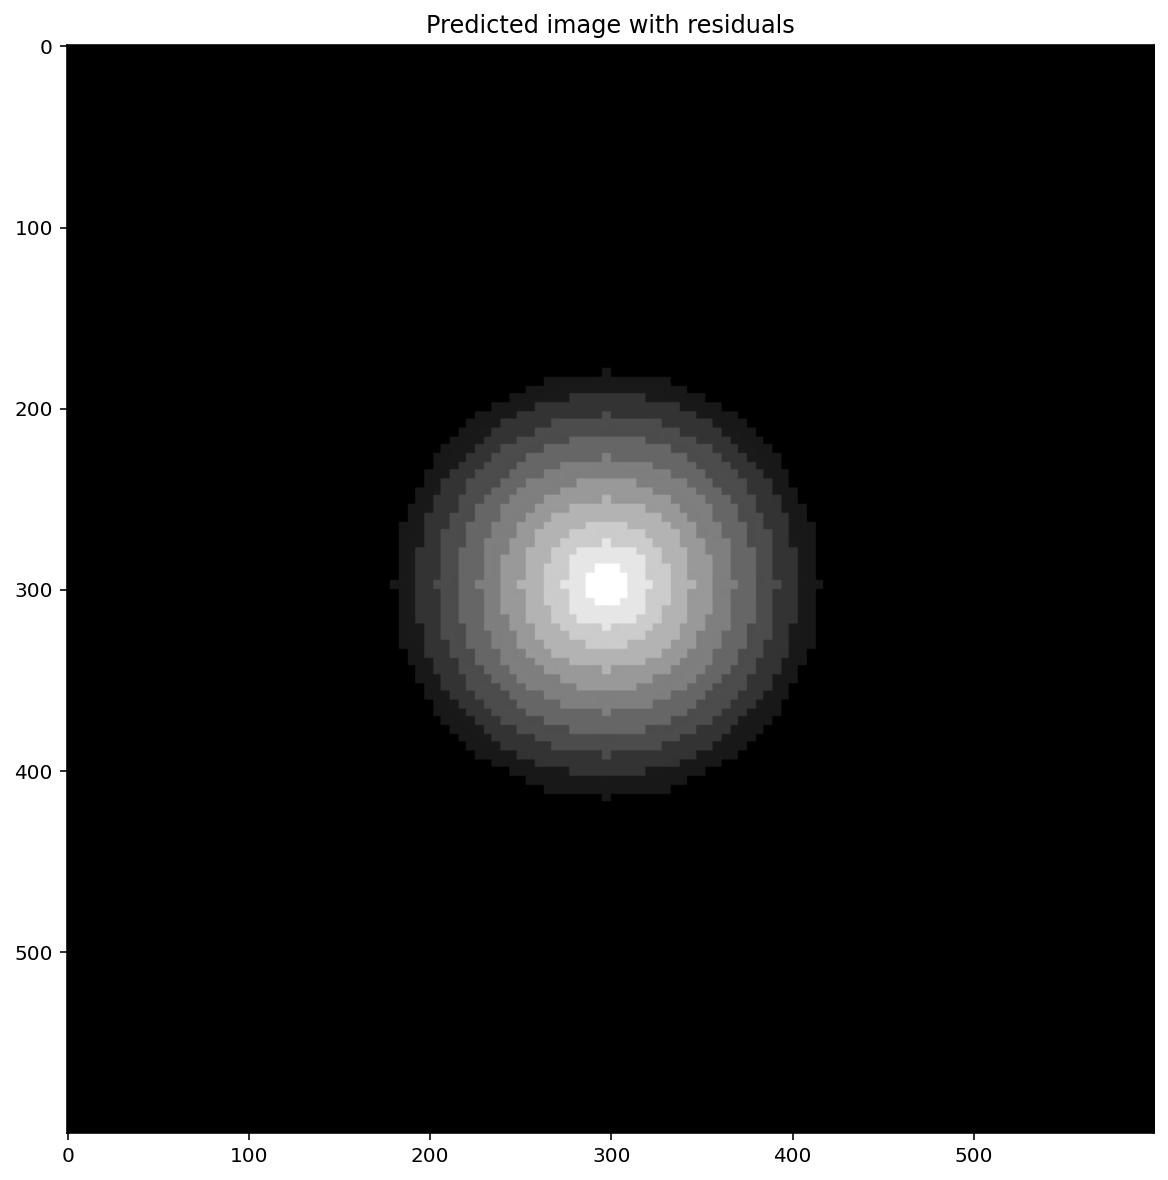

MSE: 2.894280478358269e-08
PSNR: 64.04438018798828


In [205]:
residuals = frame2 - predicted_image_non_residuals

print(f"Size of residuals {residuals.dtype}: \
      {residuals.nbytes / 1024 / 1024:.2f} MB")
# quantize residuals to uint8 (4 times smaller than float32)
print(residuals.min(), residuals.max())
max_range = 255.0 / max(abs(residuals.min()), abs(residuals.max()))
multiplier = 1.0 / max_range
residuals = residuals * (1.0 / multiplier)
residuals = np.clip((residuals + 255.0) / 2.0, 0, 255)
print(residuals.min(), residuals.max())
residuals = residuals.astype(np.uint8)
print(f"Size of residuals {residuals.dtype}: \
      {residuals.nbytes / 1024 / 1024:.2f} MB")

# use the prediction errors (residuals) to predict the frame 2 from frame 1 again,
# also using the displacements
predicted_image_residuals = \
    predict_frame_using_displacements(frame1, displacement_mesh, residuals, multiplier)
display_frame(predicted_image_residuals, "Predicted image with residuals")
print("MSE:", frame_error_mse(frame2, predicted_image_residuals))
print("PSNR:", frame_error(frame2, predicted_image_residuals))